In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
! pip install -U "neptune-client<1.0.0" pytorch-lightning --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.11.0 requires botocore<1.34.23,>=1.33.2, but you have botocore 1.29.165 which is incompatible.


In [2]:
import neptune
from pytorch_lightning.loggers import NeptuneLogger
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pytorch_lightning as L
import xgboost as xgb
import torch.nn as nn
import torch.nn.functional as F
import time
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, ModelSummary, EarlyStopping
import torch.optim as optim

In [3]:
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "logs")
# Function for setting the seed
L.seed_everything(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [4]:
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

In [5]:
# Path to the folder containing CSV files
folder_path = '/kaggle/input/bgu-i-know-what-you-did-last-measurement-time/unlabeled/unlabeled'

# List all files in the folder
n_files = len(os.listdir(folder_path))

print("Number of CSV files:", n_files)

train = pd.read_csv('/kaggle/input/bgu-i-know-what-you-did-last-measurement-time/train.csv')
print(f'Number of Labeled files: {len(train)} ({np.round(len(train)/n_files *100,3)}%)')
print(f'Number of Unlabeled files: {n_files - len(train)} ({np.round((n_files - len(train))/n_files *100,3)}%)')

# Transform activity to integers
label_order = [
    'brushing_teeth', 'idle', 'preparing_sandwich', 'reading_book',
    'stairs_down', 'stairs_up', 'typing', 'using_phone', 'using_remote_control',
    'walking_freely', 'walking_holding_a_tray', 'walking_with_handbag',
    'walking_with_hands_in_pockets', 'walking_with_object_underarm',
    'washing_face_and_hands', 'washing_mug', 'washing_plate', 'writing'
]

# Instantiate LabelEncoder
activity_encoder = LabelEncoder()

# Fit LabelEncoder with the specified order of labels
activity_encoder.fit(label_order)

# Transform the 'activity' column using the fitted LabelEncoder
train['label'] = activity_encoder.transform(train['activity'])

Number of CSV files: 124992
Number of Labeled files: 50248 (40.201%)
Number of Unlabeled files: 74744 (59.799%)


In [6]:
def assign_value(row):
    if row['sensor'] == 'smartwatch':
        return 1
    elif row['sensor'] == 'vicon' and row['body_part'] == 'hand':
        return 2
    elif row['sensor'] == 'vicon' and row['body_part'] == 'foot':
        return 3
    else:
        return None  # or whatever default value you want

# Apply the function to create the sensor_number column
train['sensor_number'] = train.apply(assign_value, axis=1)

In [7]:
def find_missing_ids(directory_path, df):
    """
    Finds IDs in a DataFrame that do not have corresponding files in the specified directory.

    Args:
    - directory_path (str): Path to the directory containing files.
    - df (pd.DataFrame): DataFrame containing IDs to check.

    Returns:
    - missing_ids_df (pd.DataFrame): DataFrame containing the missing IDs.
    """
    # List to store IDs that are not found in the directory
    missing_ids = []

    # Iterate over the files in the directory
    for file_name in os.listdir(directory_path):
        if file_name.endswith('.csv'):
            # Extract ID from the file name
            file_id = int(file_name.split('.')[0])
            # Check if the ID is not in the DataFrame
            if file_id not in df['id'].values:
                missing_ids.append(file_id)

    # Create a new DataFrame with missing IDs
    missing_ids_df = pd.DataFrame({'id': missing_ids}).sort_values(by='id')

    return missing_ids_df


# Example usage:
directory_path = '/kaggle/input/bgu-i-know-what-you-did-last-measurement-time/unlabeled/unlabeled'
test_unlabeled = find_missing_ids(directory_path, train)

In [8]:
def sample_or_duplicate(group, n_samples):
    if len(group) >= n_samples:
        return group.sample(n=n_samples, replace=False, random_state=42)  # Randomly select n_samples rows
    else:
        num_duplicates = n_samples // len(group)
        remainder = n_samples % len(group)
        duplicated = pd.concat([group] * num_duplicates + [group.sample(n=remainder, replace=False, random_state=42)])
        return duplicated

def oversample_df(df, n_samples):
    # Apply the function to each group and concatenate the results
    new_dfs = []
    for activity, group in df.groupby('activity'):
        new_dfs.append(sample_or_duplicate(group, n_samples))

    # Concatenate the results into a new DataFrame
    new_df = pd.concat(new_dfs)

    # Reset the index
    new_df.reset_index(drop=True, inplace=True)
    return new_df

In [9]:
print(train.dtypes)

Unnamed: 0          int64
userid             object
activity           object
sensor             object
body_part          object
side               object
id                  int64
sequence_length     int64
label               int64
sensor_number       int64
dtype: object


In [20]:
train.head()

,Unnamed: 0,userid,activity,sensor,body_part,side,id,sequence_length,label,sensor_number
0,0,user01,stairs_up,smartwatch,hand,right,3387,3000,5,1
1,1,user01,walking_with_hands_in_pockets,smartwatch,hand,left,8473,4000,12,1
2,2,user08,walking_with_hands_in_pockets,smartwatch,hand,right,74365,3000,12,1
3,3,user01,walking_freely,smartwatch,hand,right,6223,3000,9,1
4,4,user07,using_phone,vicon,hand,left,61641,4000,7,2


In [21]:
train.describe()

,Unnamed: 0,id,sequence_length,label,sensor_number
count,50248.0000,50248.000000,50248.000000,50248.000000,50248.000000
mean,25123.5000,38664.997313,3491.760866,9.160384,1.422186
std,14505.4925,22322.819331,407.933470,4.573515,0.727065
min,0.0000,0.000000,3000.000000,0.000000,1.000000
25%,12561.7500,19347.500000,3000.000000,7.000000,1.000000
50%,25123.5000,38727.500000,3500.000000,10.000000,1.000000
75%,37685.2500,57974.250000,4000.000000,13.000000,2.000000
max,50247.0000,77303.000000,4000.000000,17.000000,3.000000


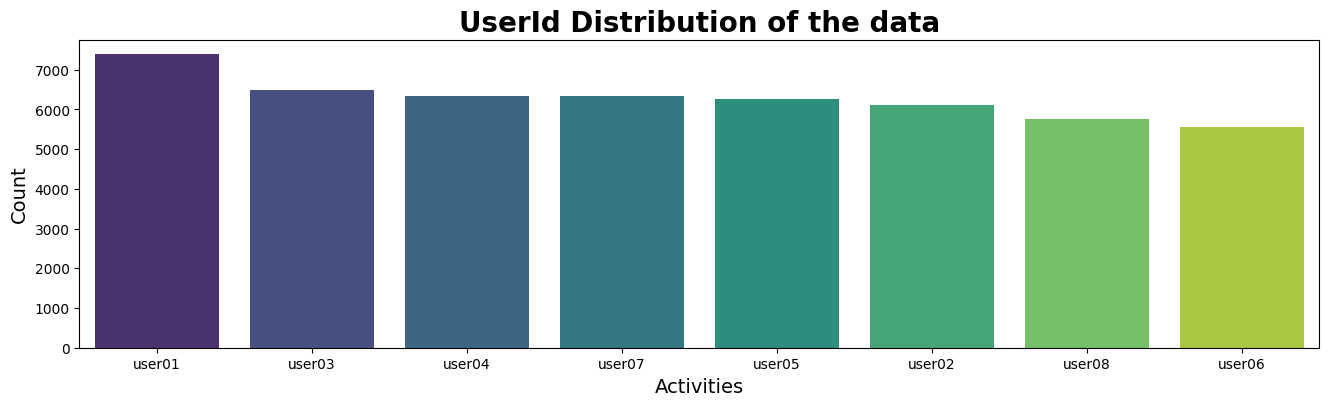

In [22]:
def get_userid_dist(df, title):
    labels = df['userid']
    label_counts = labels.value_counts()

    plt.figure(figsize=(16, 4))
    sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis', linewidth=0.1)
    
    # Title with increased font size and bold
    plt.title(title, fontsize=20, fontweight='bold')
    
    # X and Y labels with increased font size
    plt.xlabel('Activities', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    
    # Set custom tick labels with newline characters
    tick_labels = [label.replace('_', '\n') for label in label_counts.index]
    plt.xticks(range(len(label_counts)), tick_labels)
    
    plt.show()

# Class Distribution of Train
get_userid_dist(train, 'UserId Distribution of the data')

In [23]:
userid_counts = train['userid'].value_counts()

# Calculate the total number of rows
total_rows = len(train)

# Calculate the percentage of rows for each userid
percentage_per_userid = round(userid_counts / total_rows * 100, 2)

print(percentage_per_userid)

userid
user01    14.70
user03    12.92
user04    12.63
user07    12.60
user05    12.46
user02    12.14
user08    11.45
user06    11.09
Name: count, dtype: float64


### We will use user01 for test and users 02 and 06 for validation, since we know that in the unlabeled data, there are users who dont appear in the train data

In [23]:
def get_class_dist(df, title):
    labels = df['activity']
    label_counts = labels.value_counts()

    plt.figure(figsize=(16, 4))
    sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis', linewidth=0.1)
    
    # Title with increased font size and bold
    plt.title(title, fontsize=20, fontweight='bold')
    
    # X and Y labels with increased font size
    plt.xlabel('Activities', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    
    # Set custom tick labels with newline characters
    tick_labels = [label.replace('_', '\n') for label in label_counts.index]
    plt.xticks(range(len(label_counts)), tick_labels)
    
    plt.show()

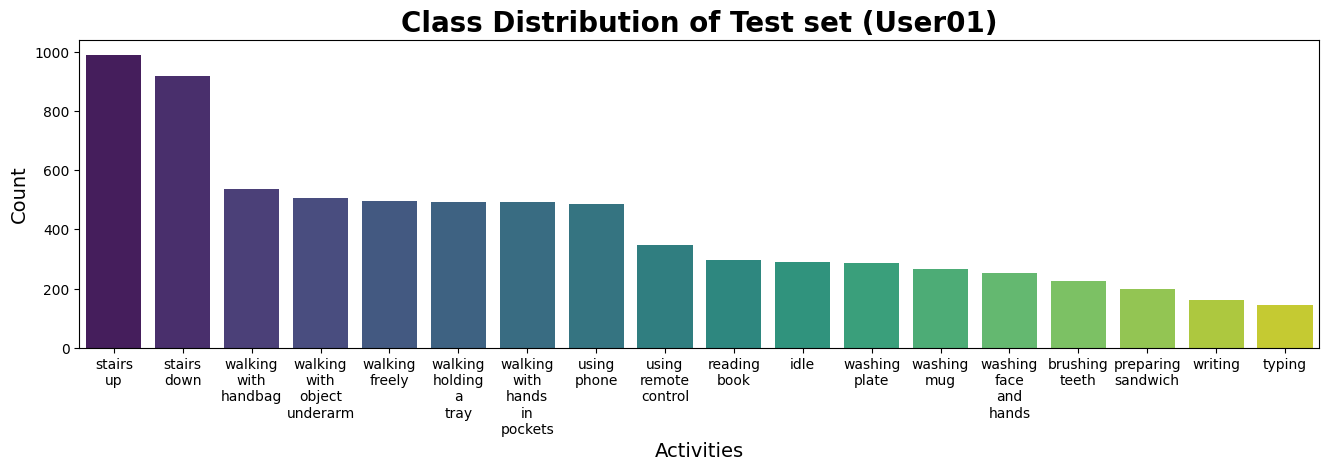

In [24]:
X_test = train[(train['userid'] == 'user01')]

# Class Distribution of Train
get_class_dist(X_test, 'Class Distribution of Test set (User01)')

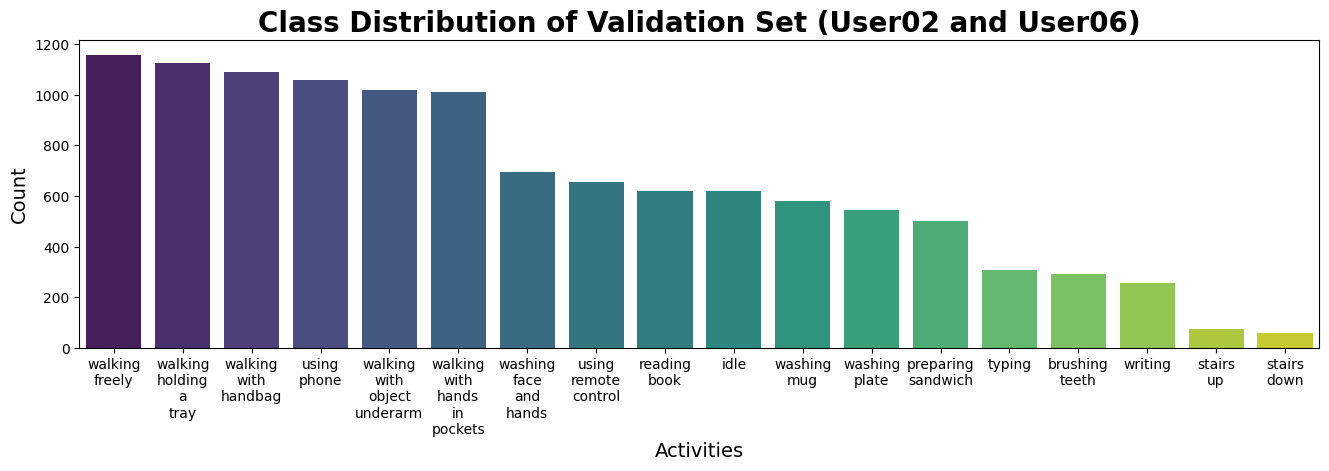

In [25]:
X_val = train[(train['userid'] == 'user02') | (train['userid'] == 'user06')]

get_class_dist(X_val, 'Class Distribution of Validation Set (User02 and User06)')

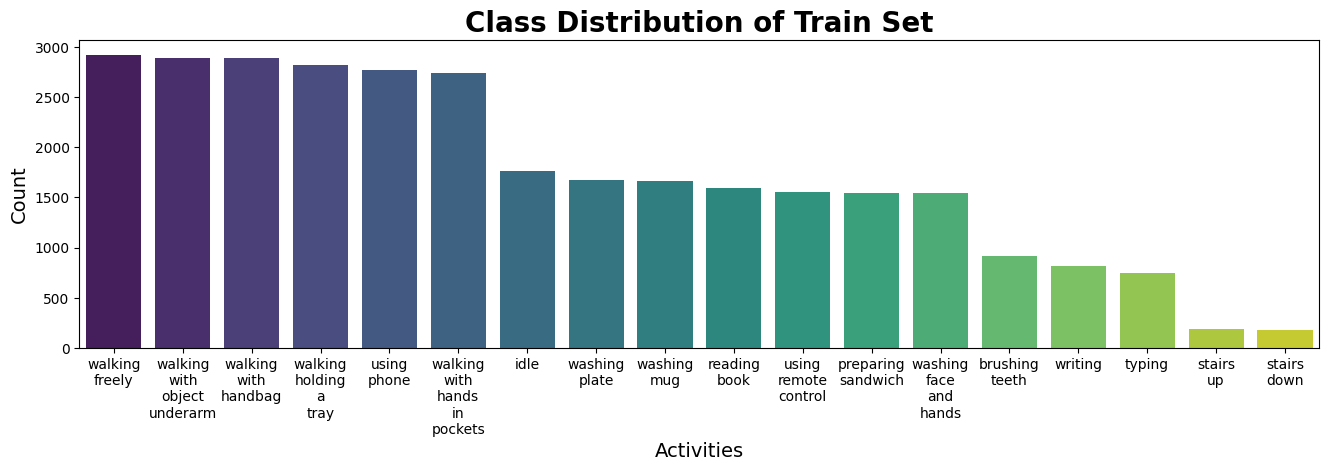

In [26]:
X_train = train[(train['userid'] == 'user03') | (train['userid'] == 'user04')| (train['userid'] == 'user05')| (train['userid'] == 'user07')| (train['userid'] == 'user08')]

# Class Distribution of Train
get_class_dist(X_train, 'Class Distribution of Train Set')

In [27]:
print(f'Number of different acitivities:', len(train['activity'].value_counts()))
X_train['activity'].value_counts()

Number of different acitivities: 18


activity
walking_freely                   2922
walking_with_object_underarm     2885
walking_with_handbag             2885
walking_holding_a_tray           2820
using_phone                      2768
walking_with_hands_in_pockets    2740
idle                             1765
washing_plate                    1671
washing_mug                      1658
reading_book                     1590
using_remote_control             1551
preparing_sandwich               1542
washing_face_and_hands           1540
brushing_teeth                    916
writing                           817
typing                            747
stairs_up                         192
stairs_down                       179
Name: count, dtype: int64

### Oversampling and downsampling such that each activity has 2000 samples. Since we choose randomly 128 segments whenever we read a csv file, we are making 'artificial samples' and Augment the data

In [21]:
X_train = oversample_df(X_train, 2000)

In [16]:
X_train['activity'].value_counts()

activity
brushing_teeth                   2000
idle                             2000
preparing_sandwich               2000
reading_book                     2000
stairs_down                      2000
stairs_up                        2000
typing                           2000
using_phone                      2000
using_remote_control             2000
walking_freely                   2000
walking_holding_a_tray           2000
walking_with_handbag             2000
walking_with_hands_in_pockets    2000
walking_with_object_underarm     2000
washing_face_and_hands           2000
washing_mug                      2000
washing_plate                    2000
writing                          2000
Name: count, dtype: int64

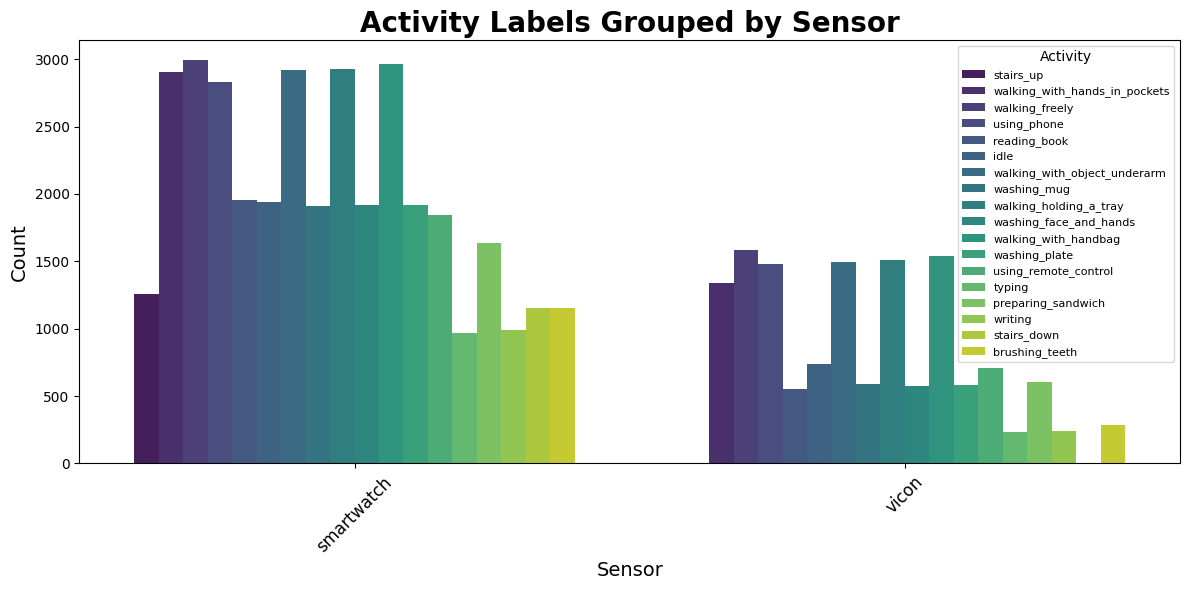

In [53]:
def plot_activity_by_sensor(df, title):
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df, x='sensor', hue='activity', palette='viridis')
    plt.title(title, fontsize=20, fontweight='bold')
    plt.xlabel('Sensor', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(fontsize=12, rotation=45)
    plt.legend(title='Activity', fontsize=8, loc='upper right')
    plt.tight_layout()
    plt.show()

# Plot activity labels grouped by sensor
plot_activity_by_sensor(train, 'Activity Labels Grouped by Sensor')


In [54]:
sample_df = pd.read_csv('/kaggle/input/bgu-i-know-what-you-did-last-measurement-time/unlabeled/unlabeled/0.csv')
print(f'Sample time series sequence length: {len(sample_df)}')
print("Other samples has 3000, 3500 and 4000 sequence length")
print(f'Each sequence has 3 values: x, y, z')
sample_df['measurement type'].value_counts()

Sample time series sequence length: 3000
Other samples has 3000, 3500 and 4000 sequence length
Each sequence has 3 values: x, y, z


measurement type
acceleration [m/s/s]    1006
magnetometer [uT]        999
gyroscope [rad/s]        995
Name: count, dtype: int64

## 2.a

In [ ]:
def calculate_sum(file_path):
#     data = np.genfromtxt(file_path, delimiter=',', skip_header=1, dtype=float, invalid_raise=False)
    data = pd.read_csv(file_path)
    if data.shape[1] == 4:
        data = data[data['measurement type'] == 'acceleration [m/s/s]']
        data = data.drop(columns=data.columns[0])
    
    data = data.values
    sum_arr = np.sum(data, axis=0)
    sum_x, sum_y, sum_z = sum_arr[0], sum_arr[1], sum_arr[2]
    length = data.shape[0]
    
    return sum_x, sum_y, sum_z, length

def calculate_mean_all_files(df):
    total_weight = 0
    weighted_sum_x = 0
    weighted_sum_y = 0
    weighted_sum_z= 0
    
    for id in df['id']:
        full_file_path = f'/kaggle/input/bgu-i-know-what-you-did-last-measurement-time/unlabeled/unlabeled/{id}.csv'
        sum_x, sum_y, sum_z, length = calculate_sum(full_file_path)
        total_weight += length
        weighted_sum_x += sum_x
        weighted_sum_y += sum_y
        weighted_sum_z += sum_z
        
    weighted_sum_x = weighted_sum_x / total_weight
    weighted_sum_y = weighted_sum_y / total_weight
    weighted_sum_z = weighted_sum_z / total_weight
    
    return weighted_sum_x, weighted_sum_y, weighted_sum_z
mean_x_3, mean_y_3, mean_z_3 = calculate_mean_all_files(train)

In [ ]:
smartwatch = train[train['sensor'] == 'smartwatch']
vicon = train[train['sensor'] == 'vicon']

mean_x_smartwatch, mean_y_smartwatch, mean_z_smartwatch = calculate_mean_all_files(smartwatch)
mean_x_vicon, mean_y_vicon, mean_z_vicon = calculate_mean_all_files(vicon)
print(f'Mean of x,y,z (smartwatch): {[mean_x_smartwatch, mean_y_smartwatch, mean_z_smartwatch]}')
print(f'Mean of x,y,z (vicon): {[mean_x_vicon, mean_y_vicon, mean_z_vicon]}')

In [ ]:
def calculate_sum_square(data, mean_list):
    # xi - u
    data_minus_mean = data - mean_list
    # (xi-u)^2
    data_square = np.square(data_minus_mean)
    sum_arr = np.sum(data_square, axis=0)
    sum_x, sum_y, sum_z = sum_arr[0], sum_arr[1], sum_arr[2]
    length = data.shape[0]
    return sum_x, sum_y, sum_z, length

def calculate_std_all_files(df, mean_list):
    total_weight = 0
    weighted_sum_x = 0
    weighted_sum_y = 0
    weighted_sum_z= 0
    
    for id in df['id']:
        file_path = f'/kaggle/input/bgu-i-know-what-you-did-last-measurement-time/unlabeled/unlabeled/{id}.csv'
        data = pd.read_csv(file_path)
        if data.shape[1] == 4:
            data = data[data['measurement type'] == 'acceleration [m/s/s]']
            data = data.drop(columns=data.columns[0])

        data = data.values 
        sum_x_square, sum_y_square, sum_z_square, length = calculate_sum_square(data, mean_list)
        total_weight += length
        weighted_sum_x += sum_x_square
        weighted_sum_y += sum_y_square
        weighted_sum_z += sum_z_square
            
    weighted_sum_x = np.sqrt(weighted_sum_x / total_weight)
    weighted_sum_y = np.sqrt(weighted_sum_y / total_weight)
    weighted_sum_z= np.sqrt(weighted_sum_z / total_weight)
    
    return weighted_sum_x, weighted_sum_y, weighted_sum_z

In [ ]:
std_x_smartwatch, std_y_smartwatch, std_z_smartwatch = calculate_std_all_files(smartwatch, [mean_x_smartwatch, mean_y_smartwatch, mean_z_smartwatch])
std_x_vicon, std_y_vicon, std_z_vicon = calculate_std_all_files(vicon, [mean_x_vicon, mean_y_vicon, mean_z_vicon])
print(f'STD of x,y,z (smartwatch): {[std_x_smartwatch, std_y_smartwatch, std_z_smartwatch]}')
print(f'STD of x,y,z (vicon): {[std_x_vicon, std_y_vicon, std_z_vicon]}')

In [ ]:
def calculate_min_max(file_path):
#     data = np.genfromtxt(file_path, delimiter=',', skip_header=1, dtype=float, invalid_raise=False)
    data = pd.read_csv(file_path)
            
    if data.shape[1] == 4:
        sensor = 4
        data = data[data['measurement type'] == 'acceleration [m/s/s]']
        data = data.drop(columns=data.columns[0])
    
    else:
        sensor = 3

    data = data.values
    length = data.shape[0]
    min_x, min_y, min_z = np.min(data[:, 0]), np.min(data[:, 1]), np.min(data[:, 2])
    max_x, max_y, max_z = np.max(data[:, 0]), np.max(data[:, 1]), np.max(data[:, 2])
    
    return min_x, min_y, min_z, max_x, max_y, max_z, length, sensor

def calculate_min_max_all_files(df):
    min_x_3_cols = float('inf')
    min_y_3_cols = float('inf')
    min_z_3_cols = float('inf')
    max_x_3_cols = float('-inf')
    max_y_3_cols = float('-inf')
    max_z_3_cols = float('-inf')
    
    min_x_4_cols = float('inf')
    min_y_4_cols = float('inf')
    min_z_4_cols = float('inf')
    max_x_4_cols = float('-inf')
    max_y_4_cols = float('-inf')
    max_z_4_cols = float('-inf')
    
    for id in df['id']:
        full_file_path = f'/kaggle/input/bgu-i-know-what-you-did-last-measurement-time/unlabeled/unlabeled/{id}.csv'
        min_x, min_y, min_z, max_x, max_y, max_z, length, sensor = calculate_min_max(full_file_path)
        
        if sensor == 3:
            min_x_3_cols = min(min_x_3_cols, min_x)
            min_y_3_cols = min(min_y_3_cols, min_y)
            min_z_3_cols = min(min_z_3_cols, min_z)
            max_x_3_cols = max(max_x_3_cols, max_x)
            max_y_3_cols = max(max_y_3_cols, max_y)
            max_z_3_cols = max(max_z_3_cols, max_z)
        else:  # sensor=4
            min_x_4_cols = min(min_x_4_cols, min_x)
            min_y_4_cols = min(min_y_4_cols, min_y)
            min_z_4_cols = min(min_z_4_cols, min_z)
            max_x_4_cols = max(max_x_4_cols, max_x)
            max_y_4_cols = max(max_y_4_cols, max_y)
            max_z_4_cols = max(max_z_4_cols, max_z)
    
    return min_x_3_cols, min_y_3_cols, min_z_3_cols, min_x_4_cols, min_y_4_cols, min_z_4_cols, \
           max_x_3_cols, max_y_3_cols, max_z_3_cols, max_x_4_cols, max_y_4_cols, max_z_4_cols

min_x_3, min_y_3, min_z_3, min_x_4, min_y_4, min_z_4, max_x_3, max_y_3, max_z_3, max_x_4, max_y_4, max_z_4 = calculate_min_max_all_files(train)


In [ ]:
print(f'Max of x,y,z (smartwatch): {[max_x_4, max_y_4, max_z_4]}')
print(f'Min of x,y,z (smartwatch): {[min_x_4, min_y_4, min_z_4]}')
print()
print(f'Max of x,y,z (vicon): {[max_x_3, max_y_3, max_z_3]}')
print(f'Min of x,y,z (vicon): {[min_x_3, min_y_3, min_z_3]}')

## 2.b

In [55]:
class NaiveModel:
    def __init__(self):
        self.most_common_label = None

    def fit(self, df):
        # Calculate the most common label
        self.most_common_label = df['label'].value_counts().idxmax()

    def predict(self, x_test):
        # Return predictions with the most common label
        return pd.Series([self.most_common_label] * len(x_test))

In [56]:
def get_accuracy(test, y_pred):
    return accuracy_score(test['label'], y_pred)

In [57]:
X_train = train[(train['userid'] == 'user02')| (train['userid'] == 'user03') | (train['userid'] == 'user04')| (train['userid'] == 'user05')| (train['userid'] == 'user06') | (train['userid'] == 'user07')| (train['userid'] == 'user08')]

naive_model = NaiveModel()
naive_model.fit(X_train)
y_pred = naive_model.predict(X_test)
get_accuracy(X_test, y_pred)

0.06728035738459456

# 2.c

In [ ]:
from scipy.stats import entropy
def calculate_metrics(seq):
    mean = np.mean(seq,axis=0)
    mean_x, mean_y, mean_z = mean.iloc[0], mean.iloc[1], mean.iloc[2]
    std = np.std(seq,axis=0)
    std_x, std_y, std_z = std.iloc[0], std.iloc[1], std.iloc[2]
    max_seq = seq.max()
    max_x, max_y, max_z = max_seq.iloc[0], max_seq.iloc[1], max_seq.iloc[2]
    min_seq = seq.min()
    min_x, min_y, min_z = min_seq.iloc[0], min_seq.iloc[1], min_seq.iloc[2]
    median = seq.median()
    median_x, median_y, median_z = median.iloc[0], median.iloc[1], median.iloc[2]
    probabilities = seq.value_counts(normalize=True)
    seq_entropy = entropy(probabilities)

    return mean_x, mean_y, mean_z, std_x, std_y, std_z, max_x, max_y, max_z, min_x, min_y, min_z, median_x, median_y, median_z, seq_entropy

In [ ]:
def calculate_stats(ids_df):
    result = []
    
    for id, label, sensor in zip(ids_df['id'], ids_df['activity'], ids_df['sensor_number']):
        file_path = f'/kaggle/input/bgu-i-know-what-you-did-last-measurement-time/unlabeled/unlabeled/{id}.csv'
        try:
            data = pd.read_csv(file_path)
            data = data.dropna()
            if data.shape[1] == 4:
                data = data[data['measurement type'] == 'acceleration [m/s/s]']
                data = data.drop(columns=data.columns[0])
                data = data.mul(0.1)
            mean_x, mean_y, mean_z, std_x, std_y, std_z, max_x, max_y, max_z, min_x, min_y, min_z, median_x, median_y, median_z, seq_entropy = calculate_metrics(data)
            if sensor  == 1:
                result.append([id, mean_x, mean_y, mean_z, std_x, std_y, std_z, max_x, max_y, max_z, min_x, min_y, min_z, median_x, median_y, median_z, seq_entropy,1,0,0, label]) 
            elif sensor == 2:
                result.append([id, mean_x, mean_y, mean_z, std_x, std_y, std_z, max_x, max_y, max_z, min_x, min_y, min_z, median_x, median_y, median_z, seq_entropy,0,1,0, label])
            else: # sensor =3
                result.append([id, mean_x, mean_y, mean_z, std_x, std_y, std_z, max_x, max_y, max_z, min_x, min_y, min_z, median_x, median_y, median_z, seq_entropy,0,0,1, label])
        except FileNotFoundError:
            print(f"File not found for id: {id}")
    
    # Define column names
    columns = ['id', 'mean_x', 'mean_y', 'mean_z', 'std_x', 'std_y', 'std_z', 'max_x', 'max_y', 'max_z', 'min_x', 'min_y', 'min_z', 'median_x', 'median_y', 'median_z', 'seq_entropy','smartwatch', 'vicon_hand', 'vicon_foot', 'activity']
    
    result_df = pd.DataFrame(result, columns=columns) # Passing column names to DataFrame constructor
    return result_df

In [ ]:
def calculate_stats_unlabeld(ids_df):
    result = []
    
    for id, sensor in zip(ids_df['id'], ids_df['sensor_number']):
        file_path = f'/kaggle/input/bgu-i-know-what-you-did-last-measurement-time/unlabeled/unlabeled/{id}.csv'
        try:
            data = pd.read_csv(file_path)
            data = data.dropna()
            if data.shape[1] == 4:
                data = data[data['measurement type'] == 'acceleration [m/s/s]']
                data = data.drop(columns=data.columns[0])
                data = data.mul(0.1)
            mean_x, mean_y, mean_z, std_x, std_y, std_z, max_x, max_y, max_z, min_x, min_y, min_z, median_x, median_y, median_z, seq_entropy = calculate_metrics(data)
            if sensor  == 1:
                result.append([id, mean_x, mean_y, mean_z, std_x, std_y, std_z, max_x, max_y, max_z, min_x, min_y, min_z, median_x, median_y, median_z, seq_entropy,1,0,0]) 
            elif sensor == 2:
                result.append([id, mean_x, mean_y, mean_z, std_x, std_y, std_z, max_x, max_y, max_z, min_x, min_y, min_z, median_x, median_y, median_z, seq_entropy,0,1,0])
            else: # sensor =3
                result.append([id, mean_x, mean_y, mean_z, std_x, std_y, std_z, max_x, max_y, max_z, min_x, min_y, min_z, median_x, median_y, median_z, seq_entropy,0,0,1])
        except FileNotFoundError:
            print(f"File not found for id: {id}")
    
    # Define column names
    columns = ['id', 'mean_x', 'mean_y', 'mean_z', 'std_x', 'std_y', 'std_z', 'max_x', 'max_y', 'max_z', 'min_x', 'min_y', 'min_z', 'median_x', 'median_y', 'median_z', 'seq_entropy','smartwatch', 'vicon_hand', 'vicon_foot']
    
    result_df = pd.DataFrame(result, columns=columns) # Passing column names to DataFrame constructor
    return result_df

labeled data

In [ ]:
# Get the total number of rows
total_rows = len(train)

# Calculate the midpoint to split the DataFrame into two equal parts
midpoint = total_rows // 2

# Split the DataFrame into two equal parts
train1 = train.iloc[:midpoint]
train2 = train.iloc[midpoint:]

In [ ]:
train1_metrics = calculate_stats(train1)

In [ ]:
train2_metrics = calculate_stats(train2)

In [ ]:
all_train_metrics = pd.concat([train1_metrics, train2_metrics], ignore_index=False)
all_train_metrics.to_csv('/kaggle/working/all_train_metrics_mul.csv', index=False)

Unlabeled data

In [ ]:
# Get the total number of rows
total_rows = len(unlabeld_with_sensors)

# Calculate the midpoint to split the DataFrame into two equal parts
midpoint = total_rows // 2

# Split the DataFrame into two equal parts
unlabeld_with_sensors1 = unlabeld_with_sensors.iloc[:midpoint]
unlabeld_with_sensors2 = unlabeld_with_sensors.iloc[midpoint:]

In [ ]:
unlabeld1_metrics = calculate_stats_unlabeld(unlabeld_with_sensors1)

In [ ]:
unlabeld2_metrics = calculate_stats_unlabeld(unlabeld_with_sensors2)

In [ ]:
all_unlabeled_metrics = pd.concat([unlabeld1_metrics, unlabeld2_metrics], ignore_index=False)
all_unlabeled_metrics.to_csv('/kaggle/working/all_unlabeled_metrics_mul.csv', index=False)

train xgboost model

In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Assuming all_train_metrics is your DataFrame containing training data
# Read the DataFrame
all_train_metrics = pd.read_csv('/kaggle/input/all-train-metrics-mul/all_train_metrics_mul.csv')

# mean_columns = [col for col in all_train_metrics.columns if col.startswith('mean_')]
# all_train_metrics['mean_average'] = all_train_metrics[mean_columns].mean(axis=1)

# std_columns = [col for col in all_train_metrics.columns if col.startswith('std_')]
# all_train_metrics['std_average'] = all_train_metrics[std_columns].mean(axis=1)

# Separate features and target variable
X = all_train_metrics[['mean_x', 'mean_y', 'mean_z', 'std_x', 'std_y', 'std_z', 'max_x', 'max_y', 'max_z', 'min_x', 'min_y', 'min_z', 'median_x', 'median_y', 'median_z', 'seq_entropy','smartwatch', 'vicon_hand', 'vicon_foot']]
y = all_train_metrics['activity']

# Instantiate LabelEncoder
label_encoder = LabelEncoder()

# Fit LabelEncoder on training data and transform both training and test data
y_encoded = label_encoder.fit_transform(y)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Define the parameter grid for grid search
param_grid = {
    'learning_rate': [0.1, 0.01],
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 6],
}

# Instantiate XGBoost classifier
base_model = XGBClassifier()

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=base_model, param_grid=param_grid, scoring='accuracy', cv=3)

# Fit the model to the training data with grid search
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Print the best parameters found by grid search
print("Best Parameters:", grid_search.best_params_)

# Print the best score found by grid search
print("Best Accuracy Score:", grid_search.best_score_)


Best Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}
Best Accuracy Score: 0.8977810161818714


In [3]:
# Get the best parameters found by grid search
best_params = grid_search.best_params_

# Instantiate XGBClassifier with the best parameters
final_model = XGBClassifier(**best_params)

# Train the final model on the training data
final_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = final_model.predict(X_test)

# Evaluate the predictions
accuracy = np.mean(y_pred == y_test)
print("Test Accuracy:", accuracy)


Test Accuracy: 0.9145273631840796


In [ ]:
all_unlabeled_metrics1 = all_unlabeled_metrics[['mean_x', 'mean_y', 'mean_z', 'std_x', 'std_y', 'std_z', 'max_x', 'max_y', 'max_z', 'min_x', 'min_y', 'min_z', 'median_x', 'median_y', 'median_z', 'seq_entropy','smartwatch', 'vicon_hand', 'vicon_foot']]

In [ ]:
pred_for_submission = final_model.predict_proba(all_unlabeled_metrics1)

In [ ]:
# Create a DataFrame with IDs, predicted labels, actual labels, and their corresponding probabilities for each class
preds_for_sub_df = pd.DataFrame(pred_for_submission, columns=label_encoder.classes_, index=all_unlabeled_metrics['id'].values)

# Save the DataFrame to a CSV file
preds_for_sub_df.to_csv('/kaggle/working/preds_for_sub_df10.csv')

# 2.d.

In [12]:
def sample_rows_from_each_label(df, label_column, n):
    """
    Sample n rows from each group defined by the 'label' column in the DataFrame.
    
    Parameters:
        df (DataFrame): Input DataFrame.
        label_column (str): Name of the column containing the labels.
        n (int): Number of rows to sample from each group.
    
    Returns:
        DataFrame: Sampled DataFrame containing n rows from each group.
    """
    sampled_df = df.groupby(label_column, group_keys=False).apply(lambda x: x.sample(min(len(x), n)))
    return sampled_df

X_train_undersample = sample_rows_from_each_label(X_train, 'label', 50)
X_val_undersample = sample_rows_from_each_label(X_val, 'label', 30)
X_test_undersample = sample_rows_from_each_label(X_test, 'label', 30)

/tmp/ipykernel_34/3830126370.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby(label_column, group_keys=False).apply(lambda x: x.sample(min(len(x), n)))
/tmp/ipykernel_34/3830126370.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby(label_column, group_keys=False).apply(lambda x: x.sample(min(len(x), n)))
/tmp/ipykernel_34/3830126370.py:13: DeprecationWar

In [9]:
class HAR_dataset(Dataset):
    def __init__(self, df, id_position, size):
        self.df = df
        self.mean_3 = torch.tensor([-0.15818902943711796, -0.2912071196803542, 0.5813256905174803]).float()
        self.mean_4 = torch.tensor([1.0851000392802572, 4.980813514517233, -0.20413086913638567]).float()
        self.std_3 = torch.tensor([0.6437729127123676, 0.8524435486898168, 0.4172358907814035]).float()
        self.std_4 = torch.tensor([16.79127047938146, 15.200511285737033, 12.513116639746222]).float()
        self.id_position = id_position
        self.size = size
        self.sensor = 3
        
    def __getitem__(self, idx):
        if self.id_position == 6:
            id = torch.tensor(self.df.iloc[idx, 6])
            label = torch.tensor(self.df.iloc[idx, 8])
        elif self.id_position == 0: # Test
            id = torch.tensor(self.df.iloc[idx, 0])
        else:
            print('Error in id_position')
        file_path = f'/kaggle/input/bgu-i-know-what-you-did-last-measurement-time/unlabeled/unlabeled/{id}.csv'
        sample_df = pd.read_csv(file_path)
            
        if sample_df.shape[1] == 4:
            self.sensor = 4
            sample_df = sample_df[sample_df['measurement type'] == 'acceleration [m/s/s]']
            sample_df = sample_df.drop(columns=sample_df.columns[0])
            
        # Make sure that all columns names are the same
        sample_df = sample_df.dropna()
        sample_df.columns = ['x', 'y', 'z']
        random_indices = np.random.choice(len(sample_df), size=self.size, replace=False)
        undersampled_data = sample_df.iloc[random_indices].sort_index().values
        undersampled_data_tensor = torch.tensor(undersampled_data)
        
        # Normalizing
        if self.sensor == 4:
            scaled_tensor = (undersampled_data_tensor - self.mean_4) / self.std_4
        else:
            scaled_tensor = (undersampled_data_tensor - self.mean_3) / self.std_3
            
        scaled_tensor = scaled_tensor.float()
        
        if self.id_position == 6:
            return scaled_tensor, label
        elif self.id_position == 0: # Test
            return scaled_tensor, id
        else:
            print('Error in id_position')

    def __len__(self):
        return len(self.df)

In [10]:
class HARDataModule(L.LightningDataModule):
    def __init__(self, Dataset_class, idx_position, size, train_data, val_data, test_data, batch_size=64):
        super().__init__()
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.batch_size = batch_size
        self.Dataset_class = Dataset_class
        self.idx_position = idx_position
        self.size = size

    def train_dataloader(self):
        train_dataset = self.Dataset_class(self.train_data, self.idx_position, self.size)
        return DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4)

    def val_dataloader(self):
        val_dataset = self.Dataset_class(self.val_data, self.idx_position, self.size)
        return DataLoader(val_dataset, batch_size=self.batch_size, num_workers=4)

    def test_dataloader(self):
        test_dataset = self.Dataset_class(self.test_data, self.idx_position, self.size)
        return DataLoader(test_dataset, batch_size=self.batch_size, num_workers=4)

In [11]:
def train_model(variable_model, idx_position, size, model_name, cp_path, batch_size, max_epochs, train_df,val_df, test_df, save_name=None, **kwargs):
    """
    Train a specified model on the provided data.

    Args:
    - model_name (str): Name of the model to run.
    - cp_path (str): Path to the checkpoint file for pretrained model. If None, trains from scratch.
    - batch_size (int): Batch size for training.
    - max_epochs (int): Maximum number of epochs for training.
    - train_df (DataFrame): DataFrame containing training data.
    - val_df (DataFrame): DataFrame containing validation data.
    - test_df (DataFrame): DataFrame containing test data.
    - save_name (str, optional): Name for saving checkpoints and logs. If None, defaults to model_name.

    Returns:
    - model: Trained model instance.
    - result (dict): Dictionary containing test accuracy and validation accuracy (if applicable).
    - best_model_path (str): Path to the best model checkpoint.
    """
    if save_name is None:
        save_name = model_name

    # Create a PyTorch Lightning trainer with the generation callback
    cp_callback  = ModelCheckpoint(
                save_weights_only=True, mode="max", monitor="val_acc")
    
    early_stop_callback = EarlyStopping(
                monitor='val_loss',  # Monitor validation loss for improvement
                min_delta=0.001,      # Minimum change in monitored quantity to qualify as an improvement
                patience=5,           # Number of epochs with no improvement after which training will be stopped
                verbose=False          # Print early stopping information
                )
    
    neptune_logger = NeptuneLogger(
    project="odedregev/HAR-Data",
    name=f'Find-HyperParams {model_name}',
    tags=[f'Find-HyperParams {model_name}'],
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkZTc0NmE5Yi0xNjZhLTRjYWItOGUxYi1lZDdmNmY0YmI3MWUifQ==",
    log_model_checkpoints=False,
    ) 

    trainer = L.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, save_name),  # Where to save models
        # We run on a single GPU (if possible)
        accelerator="auto",
        devices=1,
        logger=neptune_logger,
        # How many epochs to train for if no patience is set
        max_epochs=max_epochs,
        callbacks=[early_stop_callback,
            cp_callback,  # Save the best checkpoint based on the maximum val_acc recorded. Saves only weights and not optimizer
            LearningRateMonitor("epoch"),
        ],  # Log learning rate every epoch
    )  # In case your notebook crashes due to the progress bar, consider increasing the refresh rate
    
    trainer.logger._log_graph = True  # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need
    
    model_hparams = kwargs.get('model_hparams')
    optimizer_name = kwargs.get('optimizer_name')
    optimizer_name = {'optimizer_name': optimizer_name}
    optimizer_hparams = kwargs.get('optimizer_hparams')

    all_hyperparams = {**model_hparams, **optimizer_name, **optimizer_hparams}
    neptune_logger.log_hyperparams(params=all_hyperparams)
    
    # Check whether pretrained model exists. If yes, load it and skip training
    if cp_path != None:
        print(f"Found pretrained model at {cp_path}, loading...")
        # Automatically loads the model with the saved hyperparameters
        model = variable_model.load_from_checkpoint(cp_path)
    else:
        model = variable_model(**kwargs)
    
    dm = HARDataModule(HAR_dataset, idx_position, size, train_df, val_df, test_df, batch_size=batch_size)
    trainer.fit(model, dm)
    
    model = variable_model.load_from_checkpoint(
          trainer.checkpoint_callback.best_model_path
      )  # Load best checkpoint after training

    # Test best model on validation and test set

    test_result = trainer.test(model, dataloaders=dm.test_dataloader(), verbose=False)
    val_result = trainer.test(model, dataloaders=dm.val_dataloader(), verbose=False)
    result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}
    return model, result, cp_callback.best_model_path, neptune_logger

In [12]:
# Perform Training and Evaluation on the provided data, measures time and clear cache from cuda
def test(variable_model, idx_position, size, model_name, cp_path, batch_size, max_epochs, train_df, val_df, test_df, model_hparams, optimizer_name, optimizer_hparams):
    """
    Perform Training and Evaluation on the provided data, measures time and clear cache from cuda

    Args:
    - model_name (str): Name of the model to run.
    - cp_path (str): Path to the checkpoint file for pretrained model. If None, trains from scratch.
    - batch_size (int): Batch size for training.
    - max_epochs (int): Maximum number of epochs for training.
    - train_df (DataFrame): DataFrame containing training data.
    - val_df (DataFrame): DataFrame containing validation data.
    - test_df (DataFrame): DataFrame containing test data.
    - model_hparams (dict): Hyperparameters for the model.
    - optimizer_name (str): Name of the optimizer to use. Supported options: "Adam", "SGD".
    - optimizer_hparams (dict): Hyperparameters for the optimizer.

    Returns:
    - chosen_model: Trained model instance.
    - model_results (dict): Dictionary containing test accuracy and validation accuracy (if applicable).
    - cp_path_new (str): Path to the best model checkpoint.
    - total_time (float): Total time taken for training and evaluation.
    """
    t = time.time()
    chosen_model, model_results, cp_path_new, neptune_logger = train_model(
    variable_model = variable_model, 
    idx_position = idx_position, 
    size = size,
    model_name=model_name,
    cp_path = cp_path,
    batch_size = batch_size,
    max_epochs = max_epochs,
    train_df = train_df,
    val_df = val_df,
    test_df = test_df,
    model_hparams=model_hparams,
    optimizer_name = optimizer_name,
    optimizer_hparams = optimizer_hparams
    )

    total_time = time.time() - t
    neptune_logger.experiment.stop()
#     torch.cuda.empty_cache()

    return (chosen_model, model_results, cp_path_new, total_time)

In [13]:
def get_params_list(dropout_list, lr_list, weight_decay_list):
    """
    Generate a list of parameter combinations for training the model.

    Args:
    - dropout_list (list): List of dropout values to try.
    - lr_list (list): List of learning rates to try.
    - weight_decay_list (list): List of weight decay values to try.

    Returns:
    - params_list (list): List of tuples, each containing a dictionary of model hyperparameters,
      the optimizer name, and a dictionary of optimizer hyperparameters.
    """
    params_list = []
    for dropout_value in dropout_list:
        for lr_value in lr_list:
            for weight_decay_value in weight_decay_list:
                  params_list.append(({'input_size':3, 
                                     'num_classes':18, 
                                     'dropout': dropout_value},
                                      "Adam", 
                                      {"lr": lr_value, 
                                       "weight_decay": weight_decay_value}))
    return params_list

In [14]:
def grid_search(variable_model, idx_position, size, params_list, X_train_grid, X_val_grid, X_test_grid, max_epochs):
    """
    Perform grid search over the provided parameter combinations.

    Args:
    - params_list (list): List of parameter combinations, each containing model hyperparameters,
    optimizer name, and optimizer hyperparameters.
    - max_epochs (int): Maximum number of epochs for training.

    Returns:
    - hyper_params_list (list): List of tuples, each containing a string representation of the
    hyperparameters and the corresponding validation accuracy.
    """
    hyper_params_list = []
    for config in params_list:
        model_hparams = config[0]
        optimizer_name = config[1]
        optimizer_hparams = config[2]
        chosen_model, model_results, cp_path_new, total_time = test(
        variable_model = variable_model, 
        idx_position = idx_position, 
        size = size,
        model_name="Hyperparams",
        cp_path = None,
        batch_size = 90,
        max_epochs = max_epochs,
        train_df = X_train_grid,
        val_df = X_val_grid,
        test_df = X_test_grid,
        model_hparams = model_hparams,
        optimizer_name = optimizer_name,
        optimizer_hparams = optimizer_hparams,
        )
        acc_results_val = model_results['val']
        hyper_params_list.append((f"params:\n{model_hparams}\n{optimizer_hparams},  validation accuracy: {np.round(acc_results_val,3)}\n", np.round(acc_results_val,3)))
    return hyper_params_list

In [15]:
def print_grid_search(hyper_params_list):
    """
    Print the results of the grid search and the best hyperparameters found.

    Args:
    - hyper_params_list (list): List of tuples, each containing a string representation of the
    hyperparameters and the corresponding validation accuracy.
    """
    best_hyper_params = max(hyper_params_list, key=lambda item: item[1])[0]
    print(f'\nBest hyperparameters: {best_hyper_params}\n')
    print('Grid Search results:')
    for x in hyper_params_list:
        print(x[0])

## 1D CNN

In [23]:
class CNN_1D(L.LightningModule):
    def __init__(self, model_hparams, optimizer_name, optimizer_hparams):
        """
        Inputs:
            model_hparams - Hyperparameters for the model, as dictionary.
            optimizer_name - Name of the optimizer to use. Currently supported: Adam, SGD
            optimizer_hparams - Hyperparameters for the optimizer, as dictionary. This includes learning rate, weight decay, etc.
        """
        super().__init__()
        # Exports the hyperparameters to a YAML file, and create "self.hparams" namespace
        self.save_hyperparameters()
        
        self.input_size = model_hparams['input_size']
        self.num_classes, self.dropout = model_hparams['num_classes'], model_hparams['dropout']
        self.loss_module = nn.CrossEntropyLoss()
        
        self.conv1d = nn.Conv1d(in_channels=3,out_channels=128,kernel_size=3,stride=1)
        self.conv1d.weight = nn.Parameter(self.conv1d.weight.double())
        if self.conv1d.bias is not None:
            self.conv1d.bias = nn.Parameter(self.conv1d.bias.double())
        self.fc1 = nn.Linear(128, 128)
        self.fc1.weight = nn.Parameter(self.fc1.weight.double())  # Set weight to Double
        self.fc1.bias = nn.Parameter(self.fc1.bias.double())
        self.fc2 = nn.Linear(128, 18)
        self.fc2.weight = nn.Parameter(self.fc2.weight.double())  # Set weight to Double
        self.fc2.bias = nn.Parameter(self.fc2.bias.double())
        self.dropout = nn. Dropout(self.dropout)
        
        self.loss_module = nn.CrossEntropyLoss()


    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = x.double()
        x = self.conv1d(x)
        x = F.relu(x)
        x = F.max_pool1d(x, kernel_size=x.size(-1))  # Global max pooling
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    

    def configure_optimizers(self):
        # We will support Adam or SGD as optimizers.
        if self.hparams.optimizer_name == "Adam":
            # AdamW is Adam with a correct implementation of weight decay (see here
            # for details: https://arxiv.org/pdf/1711.05101.pdf)
            optimizer = optim.AdamW(self.parameters(), **self.hparams.optimizer_hparams)
        elif self.hparams.optimizer_name == "SGD":
            optimizer = optim.SGD(self.parameters(), **self.hparams.optimizer_hparams)
        else:
            assert False, f'Unknown optimizer: "{self.hparams.optimizer_name}"'

        # We will reduce the learning rate by 0.1 after 100 and 150 epochs
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,100], gamma=0.1)
        return [optimizer], [scheduler]


    def training_step(self, batch, batch_idx):
        # "batch" is the output of the training data loader.
        x, labels = batch
        preds = self(x)
        loss = self.loss_module(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        # Logs the accuracy per epoch to tensorboard (weighted average over batches)
        self.log("train_acc", acc, on_step=False, on_epoch=True, logger=True, prog_bar=True)
        self.log("train_loss", loss, on_step=False, on_epoch=True, logger=True, prog_bar=True)
        return loss  # Return tensor to call ".backward" on

    def validation_step(self, batch, batch_idx):
        x, labels = batch
        preds = self(x)
        loss = self.loss_module(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()
        # By default logs it per epoch (weighted average over batches)
        self.log("val_acc", acc, prog_bar=True)
        self.log("val_loss", loss, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, labels = batch
        preds = self(x)
        loss = self.loss_module(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()
        # By default logs it per epoch (weighted average over batches)
        self.log("test_acc", acc, prog_bar=True)
        self.log("test_loss", loss, prog_bar=True)

In [ ]:
variable_model = CNN_1D
idx_position = 6
size = 950
dropout_list = [0]
lr_list = [1e-3, 1e-4]
weight_decay_list = [0.01,0.1]
params_list = get_params_list(dropout_list, lr_list, weight_decay_list)
hyper_params_list1 = grid_search(variable_model, idx_position, size, params_list,X_train_undersample, X_val_undersample, X_test_undersample, 20)

In [27]:
print_grid_search(hyper_params_list1)


Best hyperparameters: params:
{'input_size': 3, 'num_classes': 18, 'dropout': 0}
{'lr': 0.001, 'weight_decay': 0.01},  validation accuracy: 0.378


Grid Search results:
params:
{'input_size': 3, 'num_classes': 18, 'dropout': 0}
{'lr': 0.001, 'weight_decay': 0.01},  validation accuracy: 0.378

params:
{'input_size': 3, 'num_classes': 18, 'dropout': 0}
{'lr': 0.001, 'weight_decay': 0.1},  validation accuracy: 0.359

params:
{'input_size': 3, 'num_classes': 18, 'dropout': 0}
{'lr': 0.0001, 'weight_decay': 0.01},  validation accuracy: 0.204

params:
{'input_size': 3, 'num_classes': 18, 'dropout': 0}
{'lr': 0.0001, 'weight_decay': 0.1},  validation accuracy: 0.198



In [42]:
# Concat X_train and X_val
X_train = train[(train['userid'] == 'user02')| (train['userid'] == 'user03') | (train['userid'] == 'user04')| (train['userid'] == 'user05')| (train['userid'] == 'user06') | (train['userid'] == 'user07')| (train['userid'] == 'user08')]
X_train = oversample_df(X_train, 800)

In [ ]:
chosen_model_cnn, model_results_cnn, cp_path_new_cnn, total_time_cnn = test(
    variable_model = CNN_1D,
    idx_position = 6,
    size = 950,
    model_name="CNN_1D",
    cp_path = None,
    batch_size = 80,
    max_epochs = 20,
    train_df = X_train,
    val_df = X_test,
    test_df = X_test,
    model_hparams={'input_size':3, 'num_classes':18, 'dropout': 0},
    optimizer_name = "Adam",
    optimizer_hparams = {"lr": 1e-3, "weight_decay": 0.01},
)

In [47]:
model_results_cnn

{'test': 0.3965073823928833, 'val': 0.396371990442276}

## LSTM

In [24]:
class LSTMModule(L.LightningModule):
    def __init__(self, model_hparams, optimizer_name, optimizer_hparams):
        """
        Inputs:
            model_hparams - Hyperparameters for the model, as dictionary.
            optimizer_name - Name of the optimizer to use. Currently supported: Adam, SGD
            optimizer_hparams - Hyperparameters for the optimizer, as dictionary. This includes learning rate, weight decay, etc.
        """
        super().__init__()
        # Exports the hyperparameters to a YAML file, and create "self.hparams" namespace
        self.save_hyperparameters()
        
        self.input_size, self.hidden_size = model_hparams['input_size'], model_hparams['hidden_size'], 
        self.num_layers = model_hparams['num_layers']
        self.num_classes, self.dropout = model_hparams['num_classes'], model_hparams['dropout']
        
        self.model = nn.LSTM(input_size=self.input_size, 
                            hidden_size=self.hidden_size,
                            num_layers=self.num_layers, 
                            dropout=self.dropout, 
                            batch_first=True)
        
        self.norm =  torch.nn.Sequential(
                            nn.BatchNorm1d(self.hidden_size),
                            nn.Dropout(self.dropout),
        )
        
        
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(self.hidden_size, 18),
        )

        # Create loss module
        self.loss_module = nn.CrossEntropyLoss()
        # Example input for visualizing the graph in Tensorboard


    def forward(self, x):
        # Forward function that is run when visualizing the graph
        x , _ = self.model(x)
        x = x[:, -1, :]
        x  = self.norm(x)
        x = self.mlp(x)
        return x
    

    def configure_optimizers(self):
        # We will support Adam or SGD as optimizers.
        if self.hparams.optimizer_name == "Adam":
            # AdamW is Adam with a correct implementation of weight decay (see here
            # for details: https://arxiv.org/pdf/1711.05101.pdf)
            optimizer = optim.AdamW(self.parameters(), **self.hparams.optimizer_hparams)
        elif self.hparams.optimizer_name == "SGD":
            optimizer = optim.SGD(self.parameters(), **self.hparams.optimizer_hparams)
        else:
            assert False, f'Unknown optimizer: "{self.hparams.optimizer_name}"'

        # We will reduce the learning rate by 0.1 after 100 and 150 epochs
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,100], gamma=0.1)
        return [optimizer], [scheduler]


    def training_step(self, batch, batch_idx):
        # "batch" is the output of the training data loader.
        x, labels = batch
        preds = self(x)
        loss = self.loss_module(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        # Logs the accuracy per epoch to tensorboard (weighted average over batches)
        self.log("train_acc", acc, on_step=False, on_epoch=True, logger=True, prog_bar=True)
        self.log("train_loss", loss, on_step=False, on_epoch=True, logger=True, prog_bar=True)
        return loss  # Return tensor to call ".backward" on

    def validation_step(self, batch, batch_idx):
        x, labels = batch
        preds = self(x)
        loss = self.loss_module(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()
        # By default logs it per epoch (weighted average over batches)
        self.log("val_acc", acc, prog_bar=True)
        self.log("val_loss", loss, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, labels = batch
        preds = self(x)
        loss = self.loss_module(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()
        # By default logs it per epoch (weighted average over batches)
        self.log("test_acc", acc, prog_bar=True)
        self.log("test_loss", loss, prog_bar=True)

In [25]:
def get_params_list_lstm(hidden_size_list, dropout_list, lr_list, weight_decay_list):
    """
    Generate a list of parameter combinations for training the model.

    Args:
    - dropout_list (list): List of dropout values to try.
    - lr_list (list): List of learning rates to try.
    - weight_decay_list (list): List of weight decay values to try.

    Returns:
    - params_list (list): List of tuples, each containing a dictionary of model hyperparameters,
      the optimizer name, and a dictionary of optimizer hyperparameters.
    """
    params_list = []
    for hidden_size_value in hidden_size_list:
        for dropout_value in dropout_list:
            for lr_value in lr_list:
                for weight_decay_value in weight_decay_list:
                      params_list.append(({'input_size':3, 
                                         'hidden_size':hidden_size_value, 
                                         'num_layers':2, 
                                         'num_classes':18, 
                                         'dropout': dropout_value},
                                          "Adam", 
                                          {"lr": lr_value, 
                                           "weight_decay": weight_decay_value}))
    return params_list

In [ ]:
variable_model = LSTMModule
idx_position = 6
size = 128
hidden_size_list = [32]
dropout_list = [0]
lr_list = [1e-3, 1e-4]
weight_decay_list = [0.01,0.1]
params_list = get_params_list_lstm(hidden_size_list, dropout_list, lr_list, weight_decay_list)
hyper_params_list2 = grid_search(variable_model, idx_position, size, params_list, X_train_undersample, X_val_undersample, X_test_undersample, 20)

In [28]:
print_grid_search(hyper_params_list2)


Best hyperparameters: params:
{'input_size': 3, 'hidden_size': 32, 'num_layers': 2, 'num_classes': 18, 'dropout': 0}
{'lr': 0.001, 'weight_decay': 0.1},  validation accuracy: 0.233


Grid Search results:
params:
{'input_size': 3, 'hidden_size': 32, 'num_layers': 2, 'num_classes': 18, 'dropout': 0}
{'lr': 0.001, 'weight_decay': 0.01},  validation accuracy: 0.183

params:
{'input_size': 3, 'hidden_size': 32, 'num_layers': 2, 'num_classes': 18, 'dropout': 0}
{'lr': 0.001, 'weight_decay': 0.1},  validation accuracy: 0.233

params:
{'input_size': 3, 'hidden_size': 32, 'num_layers': 2, 'num_classes': 18, 'dropout': 0}
{'lr': 0.0001, 'weight_decay': 0.01},  validation accuracy: 0.072

params:
{'input_size': 3, 'hidden_size': 32, 'num_layers': 2, 'num_classes': 18, 'dropout': 0}
{'lr': 0.0001, 'weight_decay': 0.1},  validation accuracy: 0.106



In [61]:
# Concat X_train and X_val
X_train = train[(train['userid'] == 'user02')| (train['userid'] == 'user03') | (train['userid'] == 'user04')| (train['userid'] == 'user05')| (train['userid'] == 'user06') | (train['userid'] == 'user07')| (train['userid'] == 'user08')]
X_train = oversample_df(X_train, 1200)

In [ ]:
chosen_model, model_results, cp_path_new, total_time = test(
    variable_model = LSTMModule,
    idx_position = 6,
    size = 128,
    model_name="LSTM",
    cp_path = None,
    batch_size = 80,
    max_epochs = 20,
    train_df = X_train,
    val_df = X_test,
    test_df = X_test,
    model_hparams={'input_size': 3, 'hidden_size': 32, 'num_layers': 2, 'num_classes': 18, 'dropout': 0},
    optimizer_name = "Adam",
    optimizer_hparams = {"lr": 1e-3, "weight_decay": 0.1},
)

In [38]:
model_results

{'test': 0.2818464934825897, 'val': 0.2798158824443817}

## 2.e Self-surpervised

In [49]:
def train_model_self_supervised(variable_model, idx_position, size, model_name, cp_path, batch_size, max_epochs, train_df,val_df, test_df, save_name=None, **kwargs):
    """
    Train a specified model on the provided data.

    Args:
    - model_name (str): Name of the model to run.
    - cp_path (str): Path to the checkpoint file for pretrained model. If None, trains from scratch.
    - batch_size (int): Batch size for training.
    - max_epochs (int): Maximum number of epochs for training.
    - train_df (DataFrame): DataFrame containing training data.
    - val_df (DataFrame): DataFrame containing validation data.
    - test_df (DataFrame): DataFrame containing test data.
    - save_name (str, optional): Name for saving checkpoints and logs. If None, defaults to model_name.

    Returns:
    - model: Trained model instance.
    - result (dict): Dictionary containing test accuracy and validation accuracy (if applicable).
    - best_model_path (str): Path to the best model checkpoint.
    """
    if save_name is None:
        save_name = model_name

    # Create a PyTorch Lightning trainer with the generation callback
    cp_callback  = ModelCheckpoint(
                save_weights_only=True, mode="min", monitor="val_loss")
    
    early_stop_callback = EarlyStopping(
                monitor='val_loss',  # Monitor validation loss for improvement
                min_delta=0.001,      # Minimum change in monitored quantity to qualify as an improvement
                patience=5,           # Number of epochs with no improvement after which training will be stopped
                verbose=False          # Print early stopping information
                )
    
    neptune_logger = NeptuneLogger(
    project="odedregev/HAR-Data",
    name=f'Find-HyperParams {model_name}',
    tags=[f'Find-HyperParams {model_name}'],
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkZTc0NmE5Yi0xNjZhLTRjYWItOGUxYi1lZDdmNmY0YmI3MWUifQ==",
    log_model_checkpoints=False,
    ) 

    trainer = L.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, save_name),  # Where to save models
        # We run on a single GPU (if possible)
        accelerator="auto",
        devices=1,
        logger=neptune_logger,
        # How many epochs to train for if no patience is set
        max_epochs=max_epochs,
        callbacks=[early_stop_callback,
            cp_callback,  # Save the best checkpoint based on the maximum val_acc recorded. Saves only weights and not optimizer
            LearningRateMonitor("epoch"),
        ],  # Log learning rate every epoch
    )  # In case your notebook crashes due to the progress bar, consider increasing the refresh rate
    
    trainer.logger._log_graph = True  # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need
    
    model_hparams = kwargs.get('model_hparams')
    optimizer_name = kwargs.get('optimizer_name')
    optimizer_name = {'optimizer_name': optimizer_name}
    optimizer_hparams = kwargs.get('optimizer_hparams')

    all_hyperparams = {**model_hparams, **optimizer_name, **optimizer_hparams}
    neptune_logger.log_hyperparams(params=all_hyperparams)
    
    # Check whether pretrained model exists. If yes, load it and skip training
    if cp_path != None:
        print(f"Found pretrained model at {cp_path}, loading...")
        # Automatically loads the model with the saved hyperparameters
        model = variable_model.load_from_checkpoint(cp_path)
    else:
        model = variable_model(**kwargs)
    
    dm = HARDataModule(HAR_dataset, idx_position, size, train_df, val_df, test_df, batch_size=batch_size)
    trainer.fit(model, dm)
    
    model = variable_model.load_from_checkpoint(
          trainer.checkpoint_callback.best_model_path
      )  # Load best checkpoint after training

    # Test best model on validation and test set

    test_result = trainer.test(model, dataloaders=dm.test_dataloader(), verbose=False)
    val_result = trainer.test(model, dataloaders=dm.val_dataloader(), verbose=False)
    result = {"test": test_result[0]["test_loss"], "val": val_result[0]["test_loss"]}
    return model, result, cp_callback.best_model_path, neptune_logger

In [17]:
# Perform Training and Evaluation on the provided data, measures time and clear cache from cuda
def test_self_supervised(variable_model, idx_position, size, model_name, cp_path, batch_size, max_epochs, train_df, val_df, test_df, model_hparams, optimizer_name, optimizer_hparams):
    """
    Perform Training and Evaluation on the provided data, measures time and clear cache from cuda

    Args:
    - model_name (str): Name of the model to run.
    - cp_path (str): Path to the checkpoint file for pretrained model. If None, trains from scratch.
    - batch_size (int): Batch size for training.
    - max_epochs (int): Maximum number of epochs for training.
    - train_df (DataFrame): DataFrame containing training data.
    - val_df (DataFrame): DataFrame containing validation data.
    - test_df (DataFrame): DataFrame containing test data.
    - model_hparams (dict): Hyperparameters for the model.
    - optimizer_name (str): Name of the optimizer to use. Supported options: "Adam", "SGD".
    - optimizer_hparams (dict): Hyperparameters for the optimizer.

    Returns:
    - chosen_model: Trained model instance.
    - model_results (dict): Dictionary containing test accuracy and validation accuracy (if applicable).
    - cp_path_new (str): Path to the best model checkpoint.
    - total_time (float): Total time taken for training and evaluation.
    """
    t = time.time()
    chosen_model, model_results, cp_path_new, neptune_logger = train_model_self_supervised(
    variable_model = variable_model, 
    idx_position = idx_position, 
    size = size,
    model_name=model_name,
    cp_path = cp_path,
    batch_size = batch_size,
    max_epochs = max_epochs,
    train_df = train_df,
    val_df = val_df,
    test_df = test_df,
    model_hparams=model_hparams,
    optimizer_name = optimizer_name,
    optimizer_hparams = optimizer_hparams
    )

    total_time = time.time() - t
    neptune_logger.experiment.stop()
#     torch.cuda.empty_cache()

    return (chosen_model, model_results, cp_path_new, total_time)

In [18]:
def grid_search_self_supervised(variable_model, idx_position, size, params_list, X_train_grid, X_val_grid, X_test_grid, max_epochs):
    """
    Perform grid search over the provided parameter combinations.

    Args:
    - params_list (list): List of parameter combinations, each containing model hyperparameters,
    optimizer name, and optimizer hyperparameters.
    - max_epochs (int): Maximum number of epochs for training.

    Returns:
    - hyper_params_list (list): List of tuples, each containing a string representation of the
    hyperparameters and the corresponding validation accuracy.
    """
    hyper_params_list = []
    for config in params_list:
        model_hparams = config[0]
        optimizer_name = config[1]
        optimizer_hparams = config[2]
        chosen_model, model_results, cp_path_new, total_time = test_self_supervised(
        variable_model = variable_model, 
        idx_position = idx_position, 
        size = size,
        model_name="Hyperparams",
        cp_path = None,
        batch_size = 90,
        max_epochs = max_epochs,
        train_df = X_train_grid,
        val_df = X_val_grid,
        test_df = X_test_grid,
        model_hparams = model_hparams,
        optimizer_name = optimizer_name,
        optimizer_hparams = optimizer_hparams,
        )
        acc_results_val = model_results['val']
        hyper_params_list.append((f"params:\n{model_hparams}\n{optimizer_hparams},  validation accuracy: {np.round(acc_results_val,3)}\n", np.round(acc_results_val,3)))
    return hyper_params_list

In [51]:
# Perform Training and Evaluation on the provided data, measures time and clear cache from cuda
def test(variable_model, idx_position, size, model_name, cp_path, batch_size, max_epochs, train_df, val_df, test_df, self_supervised_model, model_hparams, optimizer_name, optimizer_hparams):
    """
    Perform Training and Evaluation on the provided data, measures time and clear cache from cuda

    Args:
    - model_name (str): Name of the model to run.
    - cp_path (str): Path to the checkpoint file for pretrained model. If None, trains from scratch.
    - batch_size (int): Batch size for training.
    - max_epochs (int): Maximum number of epochs for training.
    - train_df (DataFrame): DataFrame containing training data.
    - val_df (DataFrame): DataFrame containing validation data.
    - test_df (DataFrame): DataFrame containing test data.
    - model_hparams (dict): Hyperparameters for the model.
    - optimizer_name (str): Name of the optimizer to use. Supported options: "Adam", "SGD".
    - optimizer_hparams (dict): Hyperparameters for the optimizer.

    Returns:
    - chosen_model: Trained model instance.
    - model_results (dict): Dictionary containing test accuracy and validation accuracy (if applicable).
    - cp_path_new (str): Path to the best model checkpoint.
    - total_time (float): Total time taken for training and evaluation.
    """
    t = time.time()
    chosen_model, model_results, cp_path_new, neptune_logger = train_model_self_supervised(
    variable_model = variable_model, 
    idx_position = idx_position, 
    size = size,
    model_name=model_name,
    cp_path = cp_path,
    batch_size = batch_size,
    max_epochs = max_epochs,
    train_df = train_df,
    val_df = val_df,
    test_df = test_df,
    self_supervised_model = self_supervised_model,
    model_hparams=model_hparams,
    optimizer_name = optimizer_name,
    optimizer_hparams = optimizer_hparams
    )

    total_time = time.time() - t
    neptune_logger.experiment.stop()
#     torch.cuda.empty_cache()

    return (chosen_model, model_results, cp_path_new, total_time)

In [72]:
class SelfSurpevised(L.LightningModule):
    def __init__(self, model_hparams, optimizer_name, optimizer_hparams):
        """
        Inputs:
            model_hparams - Hyperparameters for the model, as dictionary.
            optimizer_name - Name of the optimizer to use. Currently supported: Adam, SGD
            optimizer_hparams - Hyperparameters for the optimizer, as dictionary. This includes learning rate, weight decay, etc.
        """
        super().__init__()
        # Exports the hyperparameters to a YAML file, and create "self.hparams" namespace
        self.save_hyperparameters()

        
        self.encoder = nn.Sequential(
            nn.Linear(950*3, 512),
            nn.ReLU(),
            nn.Linear(512, 128)
        )
        self.decoder = nn.Sequential(
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 950*3)
        )
        
        self.change_dims = lambda x: x.view(-1, 950, 3)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded =  self.change_dims(decoded)
        return decoded
    

    def configure_optimizers(self):
        # We will support Adam or SGD as optimizers.
        if self.hparams.optimizer_name == "Adam":
            # AdamW is Adam with a correct implementation of weight decay (see here
            # for details: https://arxiv.org/pdf/1711.05101.pdf)
            optimizer = optim.AdamW(self.parameters(), **self.hparams.optimizer_hparams)
        elif self.hparams.optimizer_name == "SGD":
            optimizer = optim.SGD(self.parameters(), **self.hparams.optimizer_hparams)
        else:
            assert False, f'Unknown optimizer: "{self.hparams.optimizer_name}"'

        # We will reduce the learning rate by 0.1 after 100 and 150 epochs
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,100], gamma=0.1)
        return [optimizer], [scheduler]


    def training_step(self, batch, batch_idx):
        # "batch" is the output of the training data loader.
        x, labels = batch
        preds = self(x)
        loss = F.mse_loss(preds, x)

        # Logs the accuracy per epoch to tensorboard (weighted average over batches)
        self.log("train_loss", loss, on_step=False, on_epoch=True, logger=True, prog_bar=True)
        return loss  # Return tensor to call ".backward" on

    def validation_step(self, batch, batch_idx):
        x, labels = batch
        preds = self(x)
        loss = F.mse_loss(preds, x)
        # By default logs it per epoch (weighted average over batches)
        self.log("val_loss", loss, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, labels = batch
        preds = self(x)
        loss = F.mse_loss(preds, x)
        # By default logs it per epoch (weighted average over batches)
        self.log("test_loss", loss, prog_bar=True)

In [ ]:
X_train_data, X_test_data = train_test_split(train, test_size=0.3, random_state=42)
X_test_data, X_val_data = train_test_split(X_test_data, test_size=0.5, random_state=42)

X_train_data_undersample = sample_rows_from_each_label(X_train_data, 'label', 60)
X_val_data_undersample = sample_rows_from_each_label(X_val_data, 'label', 30)
X_test_data_undersample = sample_rows_from_each_label(X_test_data, 'label', 30)

In [ ]:
variable_model = SelfSurpevised
idx_position = 6
size = 950
dropout_list = [0]
lr_list = [1e-3, 1e-4]
weight_decay_list = [0.01,0.1]
params_list = get_params_list(dropout_list, lr_list, weight_decay_list)
hyper_params_list1 = grid_search_self_supervised(variable_model, idx_position, size, params_list,X_train_data_undersample, X_val_data_undersample, X_test_data_undersample, 20)

In [34]:
print_grid_search(hyper_params_list1)


Best hyperparameters: params:
{'input_size': 3, 'num_classes': 18, 'dropout': 0}
{'lr': 0.001, 'weight_decay': 0.01},  validation accuracy: 0.029


Grid Search results:
params:
{'input_size': 3, 'num_classes': 18, 'dropout': 0}
{'lr': 0.001, 'weight_decay': 0.01},  validation accuracy: 0.029

params:
{'input_size': 3, 'num_classes': 18, 'dropout': 0}
{'lr': 0.001, 'weight_decay': 0.1},  validation accuracy: 0.026

params:
{'input_size': 3, 'num_classes': 18, 'dropout': 0}
{'lr': 0.0001, 'weight_decay': 0.01},  validation accuracy: 0.027

params:
{'input_size': 3, 'num_classes': 18, 'dropout': 0}
{'lr': 0.0001, 'weight_decay': 0.1},  validation accuracy: 0.027



In [ ]:
chosen_model_cnn, model_results_cnn, cp_path_new_cnn, total_time_cnn = test_self_supervised(
    variable_model = SelfSurpevised,
    idx_position = 6,
    size = 950,
    model_name="CNN_1D",
    cp_path = None,
    batch_size = 80,
    max_epochs = 20,
    train_df = X_train,
    val_df = X_test,
    test_df = X_test,
    model_hparams={'input_size':3, 'num_classes':18, 'dropout': 0},
    optimizer_name = "Adam",
    optimizer_hparams = {"lr": 1e-3, "weight_decay": 0.01},
)

In [27]:
model_results_cnn

{'test': 0.016060933470726013, 'val': 0.01599605567753315}

In [28]:
torch.save(chosen_model_cnn.state_dict(), "/kaggle/working/self_supervised_try.pth")

In [41]:
class CNN_1D_self_supervised(L.LightningModule):
    def __init__(self, self_supervised_model, model_hparams, optimizer_name, optimizer_hparams):
        """
        Inputs:
            model_hparams - Hyperparameters for the model, as dictionary.
            optimizer_name - Name of the optimizer to use. Currently supported: Adam, SGD
            optimizer_hparams - Hyperparameters for the optimizer, as dictionary. This includes learning rate, weight decay, etc.
        """
        super().__init__()
        # Exports the hyperparameters to a YAML file, and create "self.hparams" namespace
        self.save_hyperparameters(ignore=['self_supervised_model'])
        
        self.input_size = model_hparams['input_size']
        self.num_classes, self.dropout = model_hparams['num_classes'], model_hparams['dropout']
        self.self_supervised_model = self_supervised_model.eval()
        
        self.conv1d = nn.Conv1d(in_channels=1,out_channels=128,kernel_size=3,stride=1)
        self.conv1d.weight = nn.Parameter(self.conv1d.weight.double())
        if self.conv1d.bias is not None:
            self.conv1d.bias = nn.Parameter(self.conv1d.bias.double())
        self.fc1 = nn.Linear(128, 64)
        self.fc1.weight = nn.Parameter(self.fc1.weight.double())  # Set weight to Double
        self.fc1.bias = nn.Parameter(self.fc1.bias.double())
        self.fc2 = nn.Linear(64, 18)
        self.fc2.weight = nn.Parameter(self.fc2.weight.double())  # Set weight to Double
        self.fc2.bias = nn.Parameter(self.fc2.bias.double())
        self.dropout = nn. Dropout(self.dropout)
        
        self.loss_module = nn.CrossEntropyLoss()


    def forward(self, x):
        x = x.view(x.size(0), -1)
        with torch.no_grad():
            x = self.self_supervised_model.encoder(x)
        x = x.unsqueeze(1)
        x = x.double()
        x = self.conv1d(x)
        x = F.relu(x)
        x = F.max_pool1d(x, kernel_size=x.size(-1))  # Global max pooling
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    

    def configure_optimizers(self):
        # We will support Adam or SGD as optimizers.
        if self.hparams.optimizer_name == "Adam":
            # AdamW is Adam with a correct implementation of weight decay (see here
            # for details: https://arxiv.org/pdf/1711.05101.pdf)
            optimizer = optim.AdamW(self.parameters(), **self.hparams.optimizer_hparams)
        elif self.hparams.optimizer_name == "SGD":
            optimizer = optim.SGD(self.parameters(), **self.hparams.optimizer_hparams)
        else:
            assert False, f'Unknown optimizer: "{self.hparams.optimizer_name}"'

        # We will reduce the learning rate by 0.1 after 100 and 150 epochs
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,100], gamma=0.1)
        return [optimizer], [scheduler]


    def training_step(self, batch, batch_idx):
        # "batch" is the output of the training data loader.
        x, labels = batch
        preds = self(x)
        loss = self.loss_module(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        # Logs the accuracy per epoch to tensorboard (weighted average over batches)
        self.log("train_acc", acc, on_step=False, on_epoch=True, logger=True, prog_bar=True)
        self.log("train_loss", loss, on_step=False, on_epoch=True, logger=True, prog_bar=True)
        return loss  # Return tensor to call ".backward" on

    def validation_step(self, batch, batch_idx):
        x, labels = batch
        preds = self(x)
        loss = self.loss_module(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()
        # By default logs it per epoch (weighted average over batches)
        self.log("val_acc", acc, prog_bar=True)
        self.log("val_loss", loss, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, labels = batch
        preds = self(x)
        loss = self.loss_module(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()
        # By default logs it per epoch (weighted average over batches)
        self.log("test_acc", acc, prog_bar=True)
        self.log("test_loss", loss, prog_bar=True)

In [43]:
# Concat X_train and X_val
X_train = train[(train['userid'] == 'user02')| (train['userid'] == 'user03') | (train['userid'] == 'user04')| (train['userid'] == 'user05')| (train['userid'] == 'user06') | (train['userid'] == 'user07')| (train['userid'] == 'user08')]

In [ ]:
chosen_model_cnn, model_results_cnn, cp_path_new_cnn, total_time_cnn = test(
    variable_model = CNN_1D_self_supervised,
    idx_position = 6,
    size = 950,
    model_name="CNN_1D",
    cp_path = None,
    batch_size = 80,
    max_epochs = 20,
    train_df = X_train,
    val_df = X_test,
    test_df = X_test,
    self_supervised_model = chosen_model_cnn,
    model_hparams={'input_size':3, 'num_classes':18, 'dropout': 0},
    optimizer_name = "Adam",
    optimizer_hparams = {"lr": 1e-3, "weight_decay": 0.01},
)

In [57]:
model_results_cnn

{test: 0.301846445355897, val: 0.3194623824443547}


## 2.f Where & why is the model doing well

In [49]:
ds = HAR_dataset(X_test, 6 ,128)
test_dataloader = DataLoader(ds, batch_size=30, shuffle=False)
chosen_model_cnn.to(device)
chosen_model_cnn.eval() 
with torch.no_grad():
    for batch in test_dataloader:        
        x, labels = batch  
        x = x.to(device)  
        predictions = chosen_model_cnn(x)
        # Apply softmax
        predictions = predictions.argmax(dim=-1) 
        original_labels = activity_encoder.inverse_transform(labels)
        original_predictions = activity_encoder.inverse_transform(predictions.cpu())
        print(labels)
        print(predictions)
        print(original_labels)
        print(original_predictions)
        break

tensor([ 5, 12,  9,  3,  5,  5,  8,  3,  1, 14, 17,  4,  8,  0,  3,  4, 12,  4,
        10,  0, 13,  4, 16,  2,  9,  5, 12, 14, 10, 14])
tensor([ 5, 12,  4, 14,  4,  4,  8,  3, 17, 14,  6,  4,  1,  1,  8,  4, 13,  4,
        10, 14, 11,  4,  8, 17,  4,  4, 13, 14, 10, 14], device='cuda:0')
['stairs_up' 'walking_with_hands_in_pockets' 'walking_freely'
 'reading_book' 'stairs_up' 'stairs_up' 'using_remote_control'
 'reading_book' 'idle' 'washing_face_and_hands' 'writing' 'stairs_down'
 'using_remote_control' 'brushing_teeth' 'reading_book' 'stairs_down'
 'walking_with_hands_in_pockets' 'stairs_down' 'walking_holding_a_tray'
 'brushing_teeth' 'walking_with_object_underarm' 'stairs_down'
 'washing_plate' 'preparing_sandwich' 'walking_freely' 'stairs_up'
 'walking_with_hands_in_pockets' 'washing_face_and_hands'
 'walking_holding_a_tray' 'washing_face_and_hands']
['stairs_up' 'walking_with_hands_in_pockets' 'stairs_down'
 'washing_face_and_hands' 'stairs_down' 'stairs_down'
 'using_remote_co

#### The 1D CNN model managed to classify correctly most of stairs_up, walking_holding_a_tray and washing_face_and_hands activities

In [ ]:
ds = HAR_dataset(X_test, 6 ,128)
test_dataloader = DataLoader(ds, batch_size=50, shuffle=False)
chosen_model.to(device)
chosen_model.eval() 
with torch.no_grad():
    for batch in test_dataloader:        
        x, labels = batch  
        x = x.to(device)  
        predictions = chosen_model(x)
        # Apply softmax
        predictions = predictions.argmax(dim=-1) 
        original_labels = activity_encoder.inverse_transform(labels)
        original_predictions = activity_encoder.inverse_transform(predictions.cpu())
        print(labels)
        print(predictions)
        print(original_labels)
        print(original_predictions)
        break

#### The LSTM model managed to classify correctly most of reading_book activity

## 2.g Improvements:

In [24]:
sensor_body_part_counts = train.groupby(['sensor', 'body_part']).size()

# Displaying the counts
print(sensor_body_part_counts)

sensor      body_part
smartwatch  hand         36186
vicon       foot          7152
            hand          6910
dtype: int64


### Smartwatch is being recorded only on hand

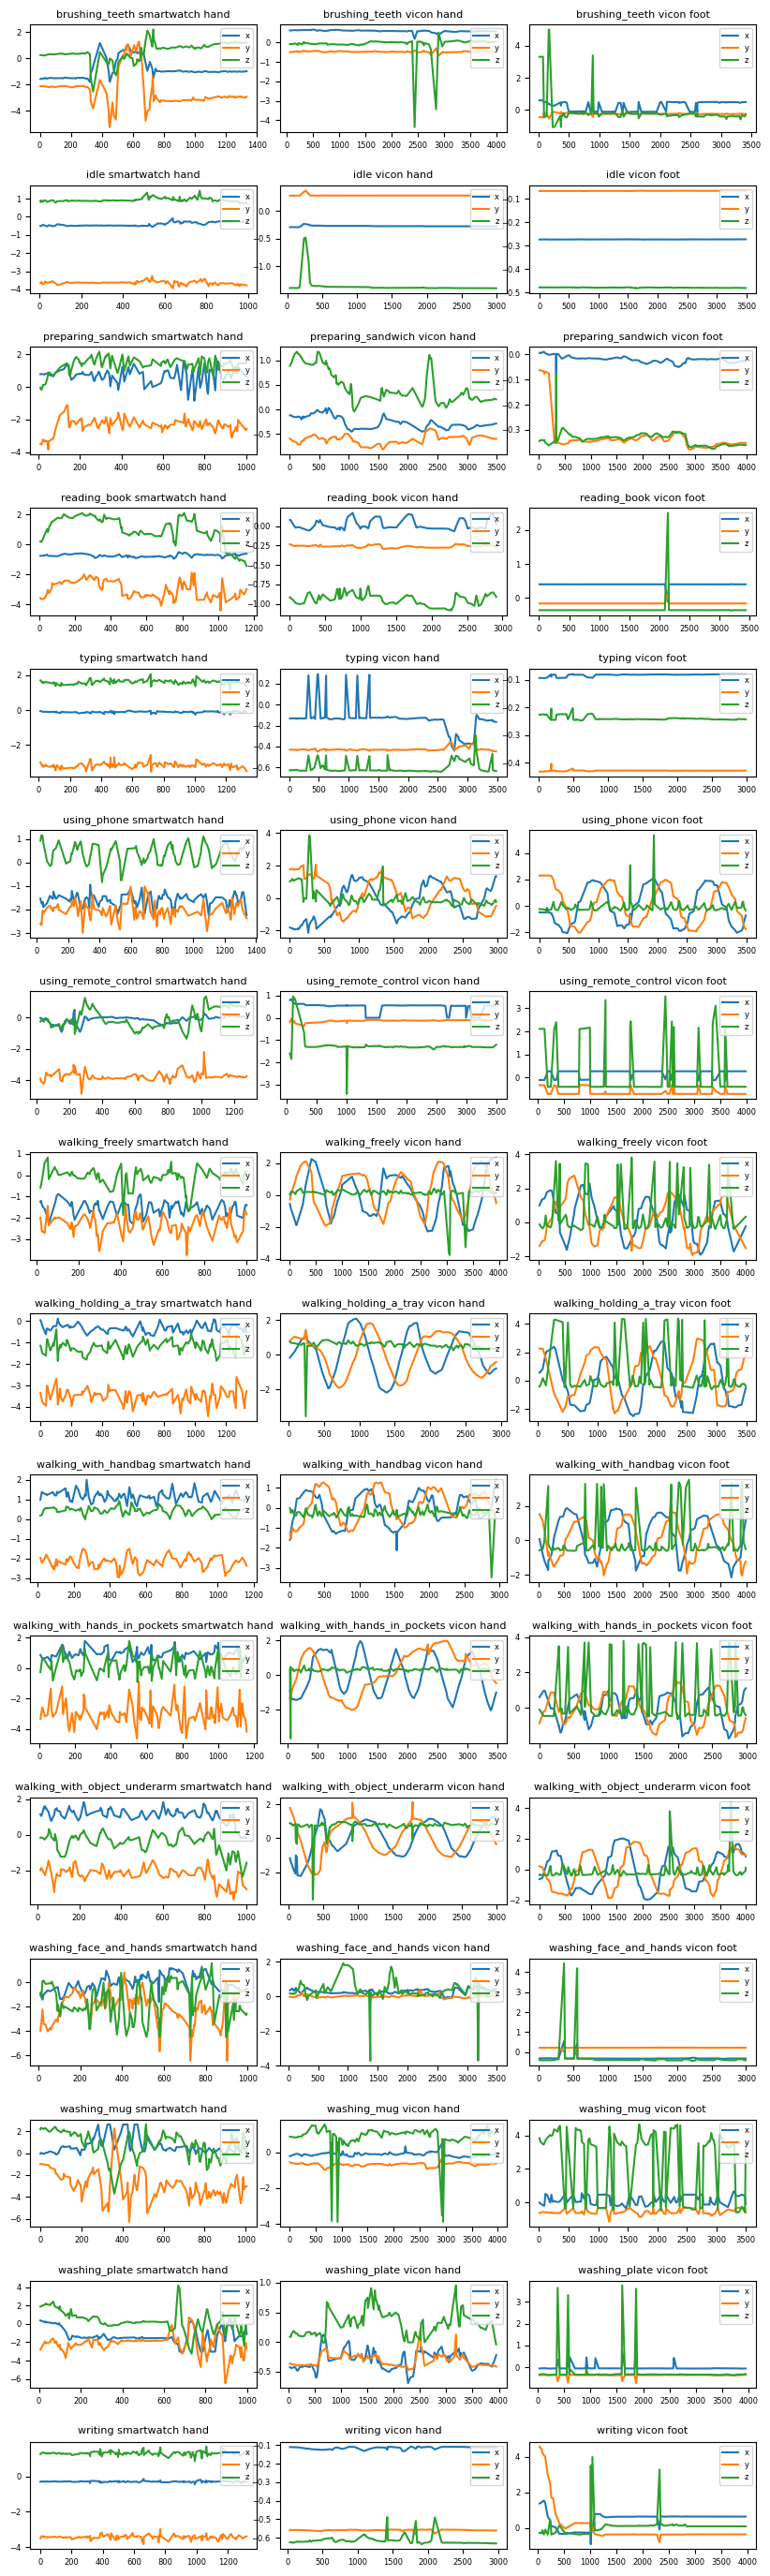

In [9]:
def plot_multiple_imgs(df1, df2, df3, nrow=16, ncol=3, figsize=(12, 8)):
    # Smartwatch
    mean_1 = np.array([1.372414189365314, 5.1932165813921385, -0.16798037138307914])
    std_1 =  np.array([6.930764616746511, 3.8525556712897377, 4.3449646665542785])

    # Vicon hand
    mean_2 =  np.array([-0.16432617006170305, -0.30075376002823967, 0.9429548188376496])
    std_2 =  np.array([0.6374844756473703, 0.8372354792243213, 0.21456465980622716])

    # Vicon foot
    mean_3 =  np.array([-0.1624986487128309, -0.2696809826159979, 0.22297777185963177])
    std_3 =  np.array([0.6555927654270958, 0.8283265607822428, 0.20572954300451923])

    fig, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=figsize)
    fig.subplots_adjust(hspace=0.5, wspace=0.1)
    
    # Concatenate the three dataframes
    concatenated_df = pd.concat([df1, df2, df3], axis=0)
    concatenated_df = concatenated_df.sort_values(by=['activity', 'sensor'])
    concatenated_df = concatenated_df[(concatenated_df['activity'] != 'stairs_down') & (concatenated_df['activity'] != 'stairs_up')]
    for i in range(48):
        id = concatenated_df.iloc[i]['id']
        sensor = concatenated_df.iloc[i]['sensor']
        part = concatenated_df.iloc[i]['body_part']
        df_sample = None
            
        df_sample = pd.read_csv(f'/kaggle/input/bgu-i-know-what-you-did-last-measurement-time/unlabeled/unlabeled/{id}.csv')

        # Filter data for 'acceleration [m/s/s]' measurement type
        if df_sample.shape[1] == 4:
            df_sample = df_sample[df_sample['measurement type'] == 'acceleration [m/s/s]']
            df_sample = df_sample.drop(columns=df_sample.columns[0])

        # Make sure that all columns names are the same
        df_sample.columns = ['x', 'y', 'z']
        df_sample.reset_index(drop=True, inplace=True)
        # Sample 100 rows with equal gap
        if len(df_sample) > 100:
            random_indices = np.random.choice(len(df_sample), size=128, replace=False)
            df_sample = df_sample.iloc[random_indices].sort_index()
            
        sensor_number = concatenated_df.iloc[i]['sensor_number']
        # Normalizing
        if sensor_number == 1: # Smartwatch
            df_sample = (df_sample - mean_1) / std_1
        elif sensor_number == 2: # Vicon hand
            df_sample = (df_sample - mean_2) / std_2
        else: # Vicon foot
            df_sample = (df_sample - mean_3) / std_3

        # Plot x, y, z values
        ax[i // ncol, i % ncol].plot(df_sample['x'], label='x')
        ax[i // ncol, i % ncol].plot(df_sample['y'], label='y')
        ax[i // ncol, i % ncol].plot(df_sample['z'], label='z')
        ax[i // ncol, i % ncol].set_title((concatenated_df.iloc[i, 2] + " " + sensor + " " + part), fontsize=8)
        ax[i // ncol, i % ncol].tick_params(axis='both', which='major', labelsize=6)
        ax[i // ncol, i % ncol].legend(fontsize=6, loc='upper right')

    plt.show()
    
def random_samples_from_each_label(df, n):
    # Group the DataFrame by the classes
    grouped_df = df.groupby('activity')

    # Initialize an empty DataFrame to store the sampled data
    sampled_df = pd.DataFrame()

    # Sample 'n' rows from each group and concatenate them
    for group, data in grouped_df:
        sampled_data = data.sample(n=min(n, len(data)), replace=False)
        sampled_df = pd.concat([sampled_df, sampled_data])

    # Reset the index of the resulting DataFrame
    sampled_df.reset_index(drop=True, inplace=True)

    return sampled_df

smartwatch = train[train['sensor'] == 'smartwatch']
vicon_hand = train[(train['sensor'] == 'vicon') & (train['body_part'] == 'hand')]
vicon_foot = train[(train['sensor'] == 'vicon') & (train['body_part'] == 'foot')]

df_smartwatch = random_samples_from_each_label(smartwatch,1)
df_vicon_hand = random_samples_from_each_label(vicon_hand,1)
df_vicon_foot = random_samples_from_each_label(vicon_foot,1)
plot_multiple_imgs(df_smartwatch, df_vicon_hand,df_vicon_foot, 16,3,(10,35))

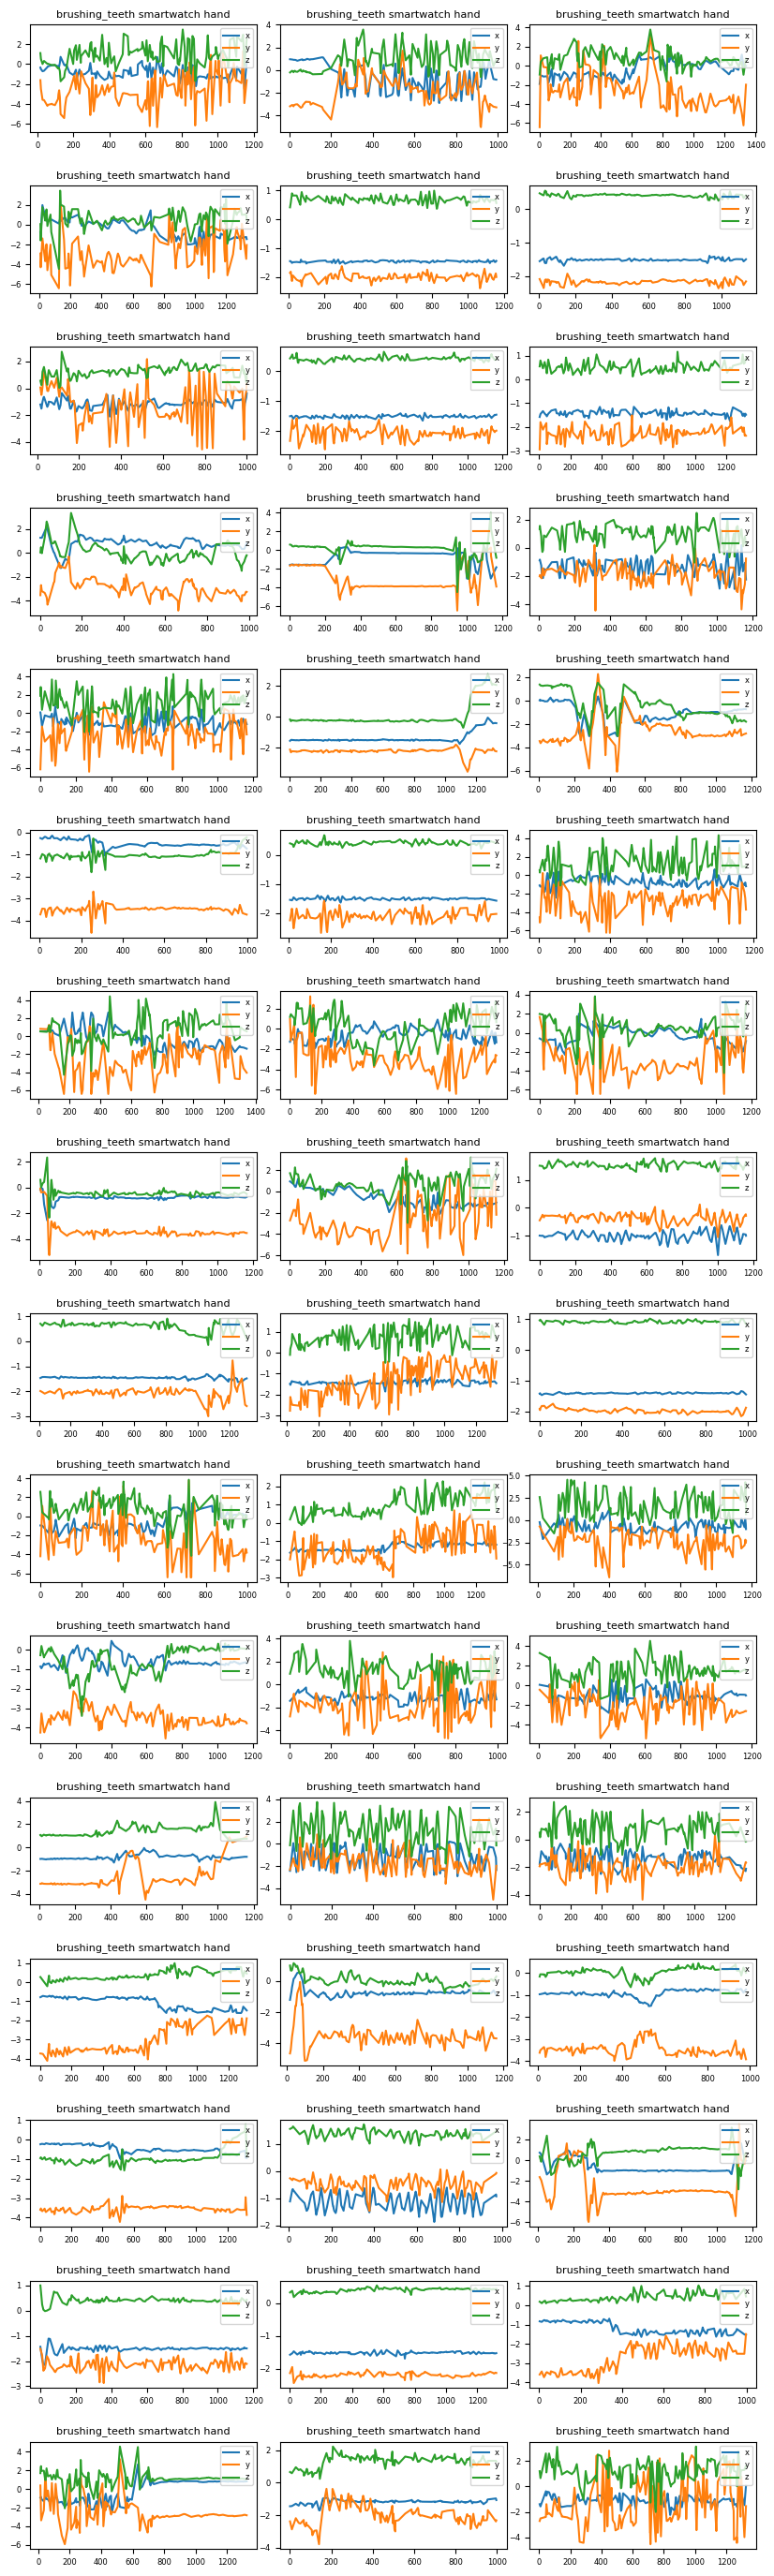

In [10]:
plot_multiple_imgs(smartwatch, vicon_hand,vicon_foot, 16,3,(10,35)) ## without sampling

#### There are major diffrences between these sensors, so we will create 3 different models for each sensor. We will use the number of columns (4) as an identifier for smartwatch, and for the other samples from vicon, we will use a LSTM model to predict vicon hand or vicon foot

### Predict if vicon is on foot or hand:

In [ ]:
vicon = train[(train['sensor'] == 'vicon')]

# Step 1: Create the new column
vicon_copy = vicon.copy()  # Create a copy of the DataFrame
vicon_copy['is_hand'] = (vicon_copy['body_part'] == 'hand').astype(float)

# Step 2: Split the dataset into train, test, and validation sets
train_data, test_data = train_test_split(vicon_copy, test_size=0.2, random_state=42)

In [ ]:
class Vicon_Dataset(Dataset):
    def __init__(self, df):
        self.df = df
        
    def __getitem__(self, idx):
        id = self.df.iloc[idx, 6]
        label = self.df.iloc[idx, 10]
        file_path = f'/kaggle/input/bgu-i-know-what-you-did-last-measurement-time/unlabeled/unlabeled/{id}.csv'
        sample_df = pd.read_csv(file_path)
        if sample_df.shape[1] == 4:
            self.sensor = 4
            sample_df = sample_df[sample_df['measurement type'] == 'acceleration [m/s/s]']
            sample_df = sample_df.drop(columns=sample_df.columns[0])
            
        # Make sure that all columns names are the same
        sample_df = sample_df.dropna()
        sample_df.columns = ['x', 'y', 'z']
        random_indices = np.random.choice(len(sample_df), size=128, replace=False)
        undersampled_data = sample_df.iloc[random_indices].sort_index().values
        undersampled_data_tensor = torch.tensor(undersampled_data)
        scaled_tensor = undersampled_data_tensor.float()
        return scaled_tensor, label

    def __len__(self):
        return len(self.df)

In [ ]:
class ViconDataModule(L.LightningDataModule):
    def __init__(self, train_data, val_data, test_data, batch_size=64):
        super().__init__()
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.batch_size = batch_size

        self.train = Vicon_Dataset(self.train_data)
        self.val = Vicon_Dataset(self.val_data)
        self.test = Vicon_Dataset(self.test_data)

    def train_dataloader(self):
        return DataLoader(self.train, self.batch_size, shuffle=True,  num_workers=4)

    def val_dataloader(self):
        return DataLoader(self.val, self.batch_size, num_workers=4)

    def test_dataloader(self):
        return DataLoader(self.test, self.batch_size, num_workers=4)

In [ ]:
class Vicon_Model(L.LightningModule):
    def __init__(self, model_hparams, optimizer_name, optimizer_hparams):
        """
        Inputs:
            model_hparams - Hyperparameters for the model, as dictionary.
            optimizer_name - Name of the optimizer to use. Currently supported: Adam, SGD
            optimizer_hparams - Hyperparameters for the optimizer, as dictionary. This includes learning rate, weight decay, etc.
        """
        super().__init__()
        # Exports the hyperparameters to a YAML file, and create "self.hparams" namespace
        self.save_hyperparameters()
        
        self.input_size, self.hidden_size = model_hparams['input_size'], model_hparams['hidden_size'], 
        self.num_layers = model_hparams['num_layers']
        
        self.model = nn.LSTM(input_size=self.input_size, 
                            hidden_size=self.hidden_size,
                            num_layers=self.num_layers, 
                            batch_first=True)
        
        self.norm =  torch.nn.Sequential(
                            nn.BatchNorm1d(self.hidden_size),
        )
        
        
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(self.hidden_size, 1),
        )
        self.sigmoid = nn.Sigmoid() 
        # Create loss module
        self.loss_module = nn.BCELoss()
        # Example input for visualizing the graph in Tensorboard


    def forward(self, x):
        # Forward function that is run when visualizing the graph
        x , _ = self.model(x)
        x = x[:, -1, :]
        x  = self.norm(x)
        x = self.mlp(x)
        x = self.sigmoid(x)
        return x
    

    def configure_optimizers(self):
        # We will support Adam or SGD as optimizers.
        if self.hparams.optimizer_name == "Adam":
            # AdamW is Adam with a correct implementation of weight decay (see here
            # for details: https://arxiv.org/pdf/1711.05101.pdf)
            optimizer = optim.AdamW(self.parameters(), **self.hparams.optimizer_hparams)
        else:
            assert False, f'Unknown optimizer: "{self.hparams.optimizer_name}"'

        # We will reduce the learning rate by 0.1 after 100 and 150 epochs
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,100], gamma=0.1)
        return [optimizer], [scheduler]


    def training_step(self, batch, batch_idx):
        # "batch" is the output of the training data loader.
        x, labels = batch
        labels = labels.unsqueeze(1).float()
        preds = self(x)
        loss = self.loss_module(preds, labels)
        binary_preds = (preds > 0.5).float()
        # Calculate accuracy by comparing binary predictions to ground truth labels
        acc = (binary_preds == labels).float().mean()

        # Logs the accuracy per epoch to tensorboard (weighted average over batches)
        self.log("train_acc", acc, on_step=False, on_epoch=True, logger=True, prog_bar=True)
        self.log("train_loss", loss, on_step=False, on_epoch=True, logger=True, prog_bar=True)
        return loss  # Return tensor to call ".backward" on

    def validation_step(self, batch, batch_idx):
        x, labels = batch
        labels = labels.unsqueeze(1).float()
        preds = self(x)
        loss = self.loss_module(preds, labels)
        binary_preds = (preds > 0.5).float()
        # Calculate accuracy by comparing binary predictions to ground truth labels
        acc = (binary_preds == labels).float().mean()
        # By default logs it per epoch (weighted average over batches)
        self.log("val_acc", acc, prog_bar=True)
        self.log("val_loss", loss, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, labels = batch
        labels = labels.unsqueeze(1).float()
        preds = self(x)
        loss = self.loss_module(preds, labels)
        binary_preds = (preds > 0.5).float()
        # Calculate accuracy by comparing binary predictions to ground truth labels
        acc = (binary_preds == labels).float().mean()
        # By default logs it per epoch (weighted average over batches)
        self.log("test_acc", acc, prog_bar=True)
        self.log("test_loss", loss, prog_bar=True)

In [ ]:
def train_model_vicon(model_name, cp_path, batch_size, max_epochs, train_df,val_df, test_df, save_name=None, **kwargs):
    """
    Train a specified model on the provided data.

    Args:
    - model_name (str): Name of the model to run.
    - cp_path (str): Path to the checkpoint file for pretrained model. If None, trains from scratch.
    - batch_size (int): Batch size for training.
    - max_epochs (int): Maximum number of epochs for training.
    - train_df (DataFrame): DataFrame containing training data.
    - val_df (DataFrame): DataFrame containing validation data.
    - test_df (DataFrame): DataFrame containing test data.
    - save_name (str, optional): Name for saving checkpoints and logs. If None, defaults to model_name.

    Returns:
    - model: Trained model instance.
    - result (dict): Dictionary containing test accuracy and validation accuracy (if applicable).
    - best_model_path (str): Path to the best model checkpoint.
    """
    if save_name is None:
        save_name = model_name
    
    early_stop_callback = EarlyStopping(
                monitor='val_loss',  # Monitor validation loss for improvement
                min_delta=0.001,      # Minimum change in monitored quantity to qualify as an improvement
                patience=5,           # Number of epochs with no improvement after which training will be stopped
                verbose=False          # Print early stopping information
                )
    
    # Create a PyTorch Lightning trainer with the generation callback
    cp_callback  = ModelCheckpoint(
                save_weights_only=True, mode="max", monitor="val_acc")
    
    neptune_logger = NeptuneLogger(
    project="odedregev/HAR-Data",
    name=f'Find-HyperParams {model_name}',
    tags=[f'Find-HyperParams {model_name}'],
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkZTc0NmE5Yi0xNjZhLTRjYWItOGUxYi1lZDdmNmY0YmI3MWUifQ==",
    log_model_checkpoints=False,
    ) 

    trainer = L.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, save_name),  # Where to save models
        # We run on a single GPU (if possible)
        accelerator="auto",
        devices=1,
        logger=neptune_logger,
        # How many epochs to train for if no patience is set
        max_epochs=max_epochs,
        callbacks=[early_stop_callback,
            cp_callback,  # Save the best checkpoint based on the maximum val_acc recorded. Saves only weights and not optimizer
            LearningRateMonitor("epoch"),
        ],  # Log learning rate every epoch
    )  # In case your notebook crashes due to the progress bar, consider increasing the refresh rate
    
    trainer.logger._log_graph = True  # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need
    
    model_hparams = kwargs.get('model_hparams')
    optimizer_name = kwargs.get('optimizer_name')
    optimizer_name = {'optimizer_name': optimizer_name}
    optimizer_hparams = kwargs.get('optimizer_hparams')

    all_hyperparams = {**model_hparams, **optimizer_name, **optimizer_hparams}
    neptune_logger.log_hyperparams(params=all_hyperparams)
    
    # Check whether pretrained model exists. If yes, load it and skip training
    if cp_path != None:
        print(f"Found pretrained model at {cp_path}, loading...")
        # Automatically loads the model with the saved hyperparameters
        model = Vicon_Model.load_from_checkpoint(cp_path)
    else:
        model = Vicon_Model(**kwargs)

    dm = ViconDataModule(train_df, val_df, test_df, batch_size=batch_size)
    trainer.fit(model, dm)
    
    model = Vicon_Model.load_from_checkpoint(
          trainer.checkpoint_callback.best_model_path
      )  # Load best checkpoint after training

    # Test best model on validation and test set

    test_result = trainer.test(model, dataloaders=dm.test_dataloader(), verbose=False)
    val_result = trainer.test(model, dataloaders=dm.val_dataloader(), verbose=False)
    result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}
    return model, result, cp_callback.best_model_path, neptune_logger

In [ ]:
# Perform Training and Evaluation on the provided data, measures time and clear cache from cuda
def test_vicon(model_name, cp_path, batch_size, max_epochs, train_df, val_df, test_df, model_hparams, optimizer_name, optimizer_hparams):
    """
    Perform Training and Evaluation on the provided data, measures time and clear cache from cuda

    Args:
    - model_name (str): Name of the model to run.
    - cp_path (str): Path to the checkpoint file for pretrained model. If None, trains from scratch.
    - batch_size (int): Batch size for training.
    - max_epochs (int): Maximum number of epochs for training.
    - train_df (DataFrame): DataFrame containing training data.
    - val_df (DataFrame): DataFrame containing validation data.
    - test_df (DataFrame): DataFrame containing test data.
    - model_hparams (dict): Hyperparameters for the model.
    - optimizer_name (str): Name of the optimizer to use. Supported options: "Adam", "SGD".
    - optimizer_hparams (dict): Hyperparameters for the optimizer.

    Returns:
    - chosen_model: Trained model instance.
    - model_results (dict): Dictionary containing test accuracy and validation accuracy (if applicable).
    - cp_path_new (str): Path to the best model checkpoint.
    - total_time (float): Total time taken for training and evaluation.
    """
    t = time.time()
    chosen_model, model_results, cp_path_new, neptune_logger = train_model_vicon(
    model_name=model_name,
    cp_path = cp_path,
    batch_size = batch_size,
    max_epochs = max_epochs,
    train_df = train_df,
    val_df = val_df,
    test_df = test_df,
    model_hparams=model_hparams,
    optimizer_name = optimizer_name,
    optimizer_hparams = optimizer_hparams
    )

    total_time = time.time() - t
    neptune_logger.experiment.stop()
    torch.cuda.empty_cache()

    return (chosen_model, model_results, cp_path_new, total_time)

In [ ]:
chosen_model, model_results, cp_path_new, total_time = test_vicon(
    model_name="Vicon",
    cp_path = None,
    batch_size = 80,
    max_epochs = 12,
    train_df = train_data,
    val_df = test_data,
    test_df = test_data,
    model_hparams={'input_size':3, 'hidden_size':32, 'num_layers':2, 'num_classes':1, 'dropout': 0},
    optimizer_name = "Adam",
    optimizer_hparams = {"lr": 1e-4, "weight_decay": 0.01},
)

In [59]:
print(model_results)

{'test': 0.9918464543565897, 'val': 0.990815435353817}


In [ ]:
vicon_model = Vicon_Model(model_hparams={'input_size':3, 'hidden_size':32, 'num_layers':2, 'num_classes':18, 'dropout': 0},
    optimizer_name = "Adam",
    optimizer_hparams = {"lr": 0.0005, "weight_decay": 0.01})
vicon_model.load_state_dict(torch.load('/kaggle/input/model-hand/model.pth'))

### Predict sensor in unlabeled data

In [ ]:
class Vicon_unlabeled_Dataset(Dataset):
    def __init__(self, df):
        self.df = df
        
    def __getitem__(self, idx):
        id = self.df.iloc[idx, 0]
        file_path = f'/kaggle/input/bgu-i-know-what-you-did-last-measurement-time/unlabeled/unlabeled/{id}.csv'
        sample_df = pd.read_csv(file_path)
        if sample_df.shape[1] == 4:
            sensor = 1
            sample_df = sample_df[sample_df['measurement type'] == 'acceleration [m/s/s]']
            sample_df = sample_df.drop(columns=sample_df.columns[0])
        else:
            sensor = 2
            
        # Make sure that all columns names are the same
        sample_df = sample_df.dropna()
        sample_df.columns = ['x', 'y', 'z']
        random_indices = np.random.choice(len(sample_df), size=128, replace=False)
        undersampled_data = sample_df.iloc[random_indices].sort_index().values
        undersampled_data_tensor = torch.tensor(undersampled_data)
        scaled_tensor = undersampled_data_tensor.float()
        return scaled_tensor, id, sensor

    def __len__(self):
        return len(self.df)
        
    

def predict_sensor(df, hand_model):
    ds = Vicon_unlabeled_Dataset(df)
    test_dataloader = DataLoader(ds, batch_size=80, shuffle=False)
    hand_model.eval() 
    hand_model.to(device)
    id_list = []
    sensor_number_list = []
    with torch.no_grad():
        for batch in test_dataloader:
            scaled_tensor, ids, sensors = batch
            scaled_tensor = scaled_tensor.to(device)
            sensors = sensors.tolist()  # Convert tensor to list for easier manipulation
            
            # Predict using hand_model for batches with sensor == 2
            sensor_2_indices = [i for i, s in enumerate(sensors) if s == 2]
            if sensor_2_indices:
                sensor_2_data = scaled_tensor[sensor_2_indices]
                sensor_2_data = sensor_2_data.to(device)
                predictions = hand_model(sensor_2_data)
                binary_preds = (predictions > 0.5).int()
                # Update sensor numbers
                for idx, pred in zip(sensor_2_indices, binary_preds):
                    if pred == 0: # foot
                        sensors[idx] = 3
                    else: # hand
                        sensors[idx] = 2
            
            # Accumulate id and sensor numbers
            id_list.extend(ids.tolist())
            sensor_number_list.extend(sensors)
            
    # Create new_df
    new_df = pd.DataFrame({'id': id_list, 'sensor_number': sensor_number_list})
    return new_df

In [ ]:
new_df = predict_sensor(test_unlabeled, chosen_model)

In [ ]:
new_df.to_csv('/kaggle/working/my_dataframe.csv', index=False)

### Combine LSTM and 1D CNN

In [41]:
X_train = train[(train['userid'] == 'user03') | (train['userid'] == 'user04')| (train['userid'] == 'user05')| (train['userid'] == 'user07')| (train['userid'] == 'user08')]
X_val = train[(train['userid'] == 'user02') | (train['userid'] == 'user06')]
X_test = train[(train['userid'] == 'user01')]

# Split data by sensor
X_train_smartwatch = X_train[X_train['sensor']=='smartwatch']
X_train_vicon_hand = X_train[(X_train['sensor']=='vicon') & (X_train['sensor_number']==2)]
X_train_vicon_foot = X_train[(X_train['sensor']=='vicon') & (X_train['sensor_number']==3)]

X_val_smartwatch = X_val[X_val['sensor']=='smartwatch']
X_val_vicon_hand = X_val[(X_val['sensor']=='vicon') & (X_val['sensor_number']==2)]
X_val_vicon_foot = X_val[(X_val['sensor']=='vicon') & (X_val['sensor_number']==3)]

X_test_smartwatch = X_test[X_test['sensor']=='smartwatch']
X_test_vicon_hand = X_test[(X_test['sensor']=='vicon') & (X_test['sensor_number']==2)]
X_test_vicon_foot = X_test[(X_test['sensor']=='vicon') & (X_test['sensor_number']==3)]

In [ ]:
# Calculate mean
mean_x_smartwatch, mean_y_smartwatch, mean_z_smartwatch = calculate_mean_all_files(X_train_smartwatch)
mean_x_vicon_hand, mean_y_vicon_hand, mean_z_vicon_hand = calculate_mean_all_files(X_train_vicon_hand)
mean_x_vicon_foot, mean_y_vicon_foot, mean_z_vicon_foot = calculate_mean_all_files(X_train_vicon_foot)

print([mean_x_smartwatch, mean_y_smartwatch, mean_z_smartwatch])
print([mean_x_vicon_hand, mean_y_vicon_hand, mean_z_vicon_hand ])
print([mean_x_vicon_foot, mean_y_vicon_foot, mean_z_vicon_foot])

In [ ]:
# Calculate std
std_x_smartwatch, std_y_smartwatch, std_z_smartwatch = calculate_std_all_files(X_train_smartwatch, [mean_x_smartwatch, mean_y_smartwatch, mean_z_smartwatch])
std_x_vicon_hand, std_y_vicon_hand, std_z_vicon_hand = calculate_std_all_files(X_train_vicon_hand, [mean_x_vicon_hand, mean_y_vicon_hand, mean_z_vicon_hand ])
std_x_vicon_foot, std_y_vicon_foot, std_z_vicon_foot = calculate_std_all_files(X_train_vicon_foot, [mean_x_vicon_foot, mean_y_vicon_foot, mean_z_vicon_foot])

print([std_x_smartwatch, std_y_smartwatch, std_z_smartwatch])
print([std_x_vicon_hand, std_y_vicon_hand, std_z_vicon_hand])
print([std_x_vicon_foot, std_y_vicon_foot, std_z_vicon_foot])

In [ ]:
# calculate mean and std for each sensor number

# Smartwatch
mean_1 = [1.372414189365314, 5.1932165813921385, -0.16798037138307914] 
std_1 = [6.930764616746511, 3.8525556712897377, 4.3449646665542785]

# Vicon hand
mean_2 = [-0.16432617006170305, -0.30075376002823967, 0.9429548188376496]
std_2 = [0.6374844756473703, 0.8372354792243213, 0.21456465980622716]

# Vicon foot
mean_3 = [-0.1624986487128309, -0.2696809826159979, 0.22297777185963177]
std_3 = [0.6555927654270958, 0.8283265607822428, 0.20572954300451923]

In [42]:
max_value_count_smartwatch = X_train_smartwatch['activity'].value_counts().iloc[0]
print(f'Max value count in smartwatch: {max_value_count_smartwatch}')

max_value_count_vicon_hand = X_train_vicon_hand['activity'].value_counts().iloc[0]
print(f'Max value count in vicon hand: {max_value_count_vicon_hand}')

max_value_count_vicon_foot = X_train_vicon_foot['activity'].value_counts().iloc[0]
print(f'Max value count in vicon foot: {max_value_count_vicon_foot}')

Max value count in smartwatch: 1920
Max value count in vicon hand: 509
Max value count in vicon foot: 528


In [23]:
# Oversampling
X_train_smartwatch = oversample_df(X_train_smartwatch, 1920)
X_train_vicon_hand = oversample_df(X_train_vicon_hand, 509)
X_train_vicon_foot = oversample_df(X_train_vicon_foot, 528)

In [20]:
class CombinedDataset(Dataset):
    def __init__(self, df):
        self.df = df
        # Smartwatch
        self.mean_1 = torch.tensor([-0.7629270933903567, -5.343777251330549, 0.6374907539635533]).float()
        self.std_1 = torch.tensor([6.930764616746511, 3.8525556712897377, 4.3449646665542785]).float()

        # Vicon hand
        self.mean_2 = torch.tensor([-0.16432617006170305, -0.30075376002823967, 0.9429548188376496]).float()
        self.std_2 = torch.tensor([0.6374844756473703, 0.8372354792243213, 0.21456465980622716]).float()

        # Vicon foot
        self.mean_3 = torch.tensor([-0.1624986487128309, -0.2696809826159979, 0.22297777185963177]).float()
        self.std_3 = torch.tensor([0.6555927654270958, 0.8283265607822428, 0.20572954300451923]).float()
        
    def __getitem__(self, idx):
        id = self.df.iloc[idx, 6]
        label = self.df.iloc[idx, 8]
        sensor_number = self.df.iloc[idx, 9]
        file_path = f'/kaggle/input/bgu-i-know-what-you-did-last-measurement-time/unlabeled/unlabeled/{id}.csv'
        sample_df = pd.read_csv(file_path)
        n_cols = sample_df.shape[1]
        if n_cols == 4:
            sample_df = sample_df[sample_df['measurement type'] == 'acceleration [m/s/s]']
            sample_df = sample_df.drop(columns=sample_df.columns[0])
            
        # Make sure that all columns names are the same
        sample_df.columns = ['x', 'y', 'z']
        sample_df = sample_df.dropna()
        random_indices = np.random.choice(len(sample_df), size=128, replace=False)
        undersampled_data = sample_df.iloc[random_indices].sort_index().values
        undersampled_data = torch.tensor(undersampled_data)
        
        # Normalizing
        if sensor_number == 1: # Smartwatch
            undersampled_data = (undersampled_data - self.mean_1) / self.std_1
        elif sensor_number == 2: # Vicon hand
            undersampled_data = (undersampled_data - self.mean_2) / self.std_2
        else: # Vicon foot
            undersampled_data = (undersampled_data - self.mean_3) / self.std_3

        undersampled_data = undersampled_data.float()
        return undersampled_data, label

    def __len__(self):
        return len(self.df)

In [21]:
class CombinedDataModule(L.LightningDataModule):
    def __init__(self, train_data, val_data, test_data, batch_size=64):
        super().__init__()
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.batch_size = batch_size

        self.train = CombinedDataset(self.train_data)
        self.val = CombinedDataset(self.val_data)
        self.test = CombinedDataset(self.test_data)

    def train_dataloader(self):
        return DataLoader(self.train, self.batch_size, shuffle=True,  num_workers=4)

    def val_dataloader(self):
        return DataLoader(self.val, self.batch_size, num_workers=4)

    def test_dataloader(self):
        return DataLoader(self.test, self.batch_size, num_workers=4)

In [22]:
class CombinedModule(L.LightningModule):
    def __init__(self, model_hparams, optimizer_name, optimizer_hparams):
        """
        Inputs:
            model_hparams - Hyperparameters for the model, as dictionary.
            optimizer_name - Name of the optimizer to use. Currently supported: Adam, SGD
            optimizer_hparams - Hyperparameters for the optimizer, as dictionary. This includes learning rate, weight decay, etc.
        """
        super().__init__()
        # Exports the hyperparameters to a YAML file, and create "self.hparams" namespace
        self.save_hyperparameters()
        
        self.input_size, self.hidden_size = model_hparams['input_size'], model_hparams['hidden_size'], 
        self.num_layers = model_hparams['num_layers']
        self.num_classes, self.dropout = model_hparams['num_classes'], model_hparams['dropout']
        
        self.lstm = nn.LSTM(input_size=self.input_size, 
                            hidden_size=self.hidden_size,
                            num_layers=self.num_layers, 
                            batch_first=True)


        self.conv1d = nn.Conv1d(in_channels=self.hidden_size,out_channels=128,kernel_size=3,stride=1)
        self.conv1d.weight = nn.Parameter(self.conv1d.weight.double())
        if self.conv1d.bias is not None:
            self.conv1d.bias = nn.Parameter(self.conv1d.bias.double())
        self.fc1 = nn.Linear(128, 128)
        self.fc1.weight = nn.Parameter(self.fc1.weight.double())  # Set weight to Double
        self.fc1.bias = nn.Parameter(self.fc1.bias.double())
        self.fc2 = nn.Linear(128, 18)
        self.fc2.weight = nn.Parameter(self.fc2.weight.double())  # Set weight to Double
        self.fc2.bias = nn.Parameter(self.fc2.bias.double())
        self.dropout = nn. Dropout(self.dropout)

        # Create loss module
        self.loss_module = nn.CrossEntropyLoss()
        # Example input for visualizing the graph in Tensorboard

        
    def forward(self, x):
        x, _ = self.lstm(x)
        x = x.permute(0, 2, 1)
        x = x.double()
        x = self.conv1d(x)
        x = F.relu(x)
        x = F.max_pool1d(x, kernel_size=x.size(-1))  # Global max pooling
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    

    def configure_optimizers(self):
        # We will support Adam or SGD as optimizers.
        if self.hparams.optimizer_name == "Adam":
            # AdamW is Adam with a correct implementation of weight decay (see here
            # for details: https://arxiv.org/pdf/1711.05101.pdf)
            optimizer = optim.AdamW(self.parameters(), **self.hparams.optimizer_hparams)

        else:
            assert False, f'Unknown optimizer: "{self.hparams.optimizer_name}"'

        # We will reduce the learning rate by 0.1 after 100 and 150 epochs
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,100], gamma=0.1)
        return [optimizer], [scheduler]


    def training_step(self, batch, batch_idx):
        # "batch" is the output of the training data loader.
        x, labels = batch
        preds = self(x)
        loss = self.loss_module(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        # Logs the accuracy per epoch to tensorboard (weighted average over batches)
        self.log("train_acc", acc, on_step=False, on_epoch=True, logger=True, prog_bar=True)
        self.log("train_loss", loss, on_step=False, on_epoch=True, logger=True, prog_bar=True)
        return loss  # Return tensor to call ".backward" on

    def validation_step(self, batch, batch_idx):
        x, labels = batch
        preds = self(x)
        loss = self.loss_module(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()
        # By default logs it per epoch (weighted average over batches)
        self.log("val_acc", acc, prog_bar=True)
        self.log("val_loss", loss, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, labels = batch
        preds = self(x)
        loss = self.loss_module(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()
        # By default logs it per epoch (weighted average over batches)
        self.log("test_acc", acc, prog_bar=True)
        self.log("test_loss", loss, prog_bar=True)

In [23]:
def train_model_combined(model_name, cp_path, batch_size, max_epochs, train_df,val_df, test_df, save_name=None, **kwargs):
    """
    Train a specified model on the provided data.

    Args:
    - model_name (str): Name of the model to run.
    - cp_path (str): Path to the checkpoint file for pretrained model. If None, trains from scratch.
    - batch_size (int): Batch size for training.
    - max_epochs (int): Maximum number of epochs for training.
    - train_df (DataFrame): DataFrame containing training data.
    - val_df (DataFrame): DataFrame containing validation data.
    - test_df (DataFrame): DataFrame containing test data.
    - save_name (str, optional): Name for saving checkpoints and logs. If None, defaults to model_name.

    Returns:
    - model: Trained model instance.
    - result (dict): Dictionary containing test accuracy and validation accuracy (if applicable).
    - best_model_path (str): Path to the best model checkpoint.
    """
    if save_name is None:
        save_name = model_name
    
    early_stop_callback = EarlyStopping(
                monitor='val_loss',  # Monitor validation loss for improvement
                min_delta=0.001,      # Minimum change in monitored quantity to qualify as an improvement
                patience=5,           # Number of epochs with no improvement after which training will be stopped
                verbose=False          # Print early stopping information
                )
    
    # Create a PyTorch Lightning trainer with the generation callback
    cp_callback  = ModelCheckpoint(
                save_weights_only=True, mode="max", monitor="val_acc")
    
    neptune_logger = NeptuneLogger(
    project="odedregev/HAR-Data",
    name=f'Find-HyperParams {model_name}',
    tags=[f'Find-HyperParams {model_name}'],
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkZTc0NmE5Yi0xNjZhLTRjYWItOGUxYi1lZDdmNmY0YmI3MWUifQ==",
    log_model_checkpoints=False,
    ) 

    trainer = L.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, save_name),  # Where to save models
        # We run on a single GPU (if possible)
        accelerator="auto",
        devices=1,
        logger=neptune_logger,
        # How many epochs to train for if no patience is set
        max_epochs=max_epochs,
        callbacks=[early_stop_callback,
            cp_callback,  # Save the best checkpoint based on the maximum val_acc recorded. Saves only weights and not optimizer
            LearningRateMonitor("epoch"),
        ],  # Log learning rate every epoch
    )  # In case your notebook crashes due to the progress bar, consider increasing the refresh rate
    
    trainer.logger._log_graph = True  # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need
    
    model_hparams = kwargs.get('model_hparams')
    optimizer_name = kwargs.get('optimizer_name')
    optimizer_name = {'optimizer_name': optimizer_name}
    optimizer_hparams = kwargs.get('optimizer_hparams')

    all_hyperparams = {**model_hparams, **optimizer_name, **optimizer_hparams}
    neptune_logger.log_hyperparams(params=all_hyperparams)
    
    # Check whether pretrained model exists. If yes, load it and skip training
    if cp_path != None:
        print(f"Found pretrained model at {cp_path}, loading...")
        # Automatically loads the model with the saved hyperparameters
        model = CombinedModule.load_from_checkpoint(cp_path)
    else:
        model = CombinedModule(**kwargs)

    dm = CombinedDataModule(train_df, val_df, test_df, batch_size=batch_size)
    trainer.fit(model, dm)
    
    model = CombinedModule.load_from_checkpoint(
          trainer.checkpoint_callback.best_model_path
      )  # Load best checkpoint after training

    # Test best model on validation and test set

    test_result = trainer.test(model, dataloaders=dm.test_dataloader(), verbose=False)
    val_result = trainer.test(model, dataloaders=dm.val_dataloader(), verbose=False)
    result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}
    return model, result, cp_callback.best_model_path, neptune_logger

In [24]:
# Perform Training and Evaluation on the provided data, measures time and clear cache from cuda
def test_combined(model_name, cp_path, batch_size, max_epochs, train_df, val_df, test_df, model_hparams, optimizer_name, optimizer_hparams):
    """
    Perform Training and Evaluation on the provided data, measures time and clear cache from cuda

    Args:
    - model_name (str): Name of the model to run.
    - cp_path (str): Path to the checkpoint file for pretrained model. If None, trains from scratch.
    - batch_size (int): Batch size for training.
    - max_epochs (int): Maximum number of epochs for training.
    - train_df (DataFrame): DataFrame containing training data.
    - val_df (DataFrame): DataFrame containing validation data.
    - test_df (DataFrame): DataFrame containing test data.
    - model_hparams (dict): Hyperparameters for the model.
    - optimizer_name (str): Name of the optimizer to use. Supported options: "Adam", "SGD".
    - optimizer_hparams (dict): Hyperparameters for the optimizer.

    Returns:
    - chosen_model: Trained model instance.
    - model_results (dict): Dictionary containing test accuracy and validation accuracy (if applicable).
    - cp_path_new (str): Path to the best model checkpoint.
    - total_time (float): Total time taken for training and evaluation.
    """
    t = time.time()
    chosen_model, model_results, cp_path_new, neptune_logger = train_model_combined(
    model_name=model_name,
    cp_path = cp_path,
    batch_size = batch_size,
    max_epochs = max_epochs,
    train_df = train_df,
    val_df = val_df,
    test_df = test_df,
    model_hparams=model_hparams,
    optimizer_name = optimizer_name,
    optimizer_hparams = optimizer_hparams
    )

    total_time = time.time() - t
    neptune_logger.experiment.stop()
    torch.cuda.empty_cache()

    return (chosen_model, model_results, cp_path_new, total_time)

In [25]:
def get_params_list(hidden_size_list, dropout_list, lr_list, weight_decay_list):
    """
    Generate a list of parameter combinations for training the model.

    Args:
    - dropout_list (list): List of dropout values to try.
    - lr_list (list): List of learning rates to try.
    - weight_decay_list (list): List of weight decay values to try.

    Returns:
    - params_list (list): List of tuples, each containing a dictionary of model hyperparameters,
      the optimizer name, and a dictionary of optimizer hyperparameters.
    """
    params_list = []
    for hidden_size_value in hidden_size_list:
        for dropout_value in dropout_list:
            for lr_value in lr_list:
                for weight_decay_value in weight_decay_list:
                      params_list.append(({'input_size':3, 
                                         'hidden_size':hidden_size_value, 
                                         'num_layers':2, 
                                         'num_classes':18, 
                                         'dropout': dropout_value},
                                          "Adam", 
                                          {"lr": lr_value, 
                                           "weight_decay": weight_decay_value}))
    return params_list

In [26]:
def grid_search_combined(params_list, X_train_grid, X_val_grid, X_test_grid, batch_size, max_epochs):
    """
    Perform grid search over the provided parameter combinations.

    Args:
    - params_list (list): List of parameter combinations, each containing model hyperparameters,
    optimizer name, and optimizer hyperparameters.
    - max_epochs (int): Maximum number of epochs for training.

    Returns:
    - hyper_params_list (list): List of tuples, each containing a string representation of the
    hyperparameters and the corresponding validation accuracy.
    """
    hyper_params_list = []
    for config in params_list:
        model_hparams = config[0]
        optimizer_name = config[1]
        optimizer_hparams = config[2]
        chosen_model, model_results, cp_path_new, total_time = test_combined(
        model_name="Hyperparams-Combined",
        cp_path = None,
        batch_size = batch_size,
        max_epochs = max_epochs,
        train_df = X_train_grid,
        val_df = X_val_grid,
        test_df = X_test_grid,
        model_hparams = model_hparams,
        optimizer_name = optimizer_name,
        optimizer_hparams = optimizer_hparams,
        )
        acc_results_val = model_results['val']
        hyper_params_list.append((f"params:\n{model_hparams}\n{optimizer_hparams},  validation accuracy: {np.round(acc_results_val,3)}\n", np.round(acc_results_val,3)))
    return hyper_params_list

In [27]:
def print_grid_search(hyper_params_list):
    """
    Print the results of the grid search and the best hyperparameters found.

    Args:
    - hyper_params_list (list): List of tuples, each containing a string representation of the
    hyperparameters and the corresponding validation accuracy.
    """
    best_hyper_params = max(hyper_params_list, key=lambda item: item[1])[0]
    print(f'\nBest hyperparameters: {best_hyper_params}\n')
    print('Grid Search results:')
    for x in hyper_params_list:
        print(x[0])

In [33]:
sampled_X_train_smartwatch = oversample_df(X_train_smartwatch, 50)
sampled_X_train_vicon_hand = oversample_df(X_train_vicon_hand, 30)
sampled_X_train_vicon_foot = oversample_df(X_train_vicon_foot, 30)

sampled_X_val_smartwatch = oversample_df(X_val_smartwatch, 50)
sampled_X_val_vicon_hand = oversample_df(X_val_vicon_hand, 30)
sampled_X_val_vicon_foot = oversample_df(X_val_vicon_foot, 30)

sampled_X_test_smartwatch = oversample_df(X_test_smartwatch, 50)
sampled_X_test_vicon_hand = oversample_df(X_test_vicon_hand, 30)
sampled_X_test_vicon_foot = oversample_df(X_test_vicon_foot, 30)

In [ ]:
# Hyper-parameters for smartwatch
hidden_size_list = [32]
dropout_list = [0]
lr_list = [0.01, 0.001]
weight_decay_list = [0.01,0.1]
params_list = get_params_list(hidden_size_list, dropout_list, lr_list, weight_decay_list)
hyper_params_list = grid_search_combined(params_list, sampled_X_train_smartwatch, sampled_X_val_smartwatch, sampled_X_test_smartwatch, 80, 20)

In [ ]:
print_grid_search(hyper_params_list)

In [60]:
print('chosen params:')
print("{'lr': 0.001, 'weight_decay': 0.1}")

chosen params:
{'lr': 0.001, 'weight_decay': 0.1}


In [ ]:
# Hyper-parameters for vicon hand
hidden_size_list = [32]
dropout_list = [0]
lr_list = [0.01, 0.001]
weight_decay_list = [0.01,0.1]
params_list = get_params_list(hidden_size_list, dropout_list, lr_list, weight_decay_list)
hyper_params_list1 = grid_search_combined(params_list, sampled_X_train_vicon_hand, sampled_X_val_vicon_hand, sampled_X_test_vicon_hand, 80, 20)

In [ ]:
print_grid_search(hyper_params_list1)

In [80]:
print('chosen params:')
print("{'lr': 0.01, 'weight_decay': 0.01}")

chosen params:
{'lr': 0.01, 'weight_decay': 0.01}


In [ ]:
# Hyper-parameters for vicon foot
hidden_size_list = [32]
dropout_list = [0]
lr_list = [0.01, 0.001]
weight_decay_list = [0.01,0.1]
params_list = get_params_list(hidden_size_list, dropout_list, lr_list, weight_decay_list)
hyper_params_list2 = grid_search_combined(params_list, sampled_X_train_vicon_foot, sampled_X_val_vicon_foot, sampled_X_test_vicon_foot, 80, 20)

In [ ]:
# Hyper-parameters for vicon foot
hidden_size_list = [32]
dropout_list = [0]
lr_list = [0.1]
weight_decay_list = [0.01,0.1]
params_list = get_params_list(hidden_size_list, dropout_list, lr_list, weight_decay_list)
hyper_params_list2 = grid_search_combined(params_list, sampled_X_train_vicon_foot, sampled_X_val_vicon_foot, sampled_X_test_vicon_foot, 80, 20)

In [35]:
print_grid_search(hyper_params_list2)


Best hyperparameters: params:
{'input_size': 3, 'hidden_size': 32, 'num_layers': 2, 'num_classes': 18, 'dropout': 0}
{'lr': 0.001, 'weight_decay': 0.01},  validation accuracy: 0.213


Grid Search results:
params:
{'input_size': 3, 'hidden_size': 32, 'num_layers': 2, 'num_classes': 18, 'dropout': 0}
{'lr': 0.01, 'weight_decay': 0.01},  validation accuracy: 0.175

params:
{'input_size': 3, 'hidden_size': 32, 'num_layers': 2, 'num_classes': 18, 'dropout': 0}
{'lr': 0.01, 'weight_decay': 0.1},  validation accuracy: 0.154

params:
{'input_size': 3, 'hidden_size': 32, 'num_layers': 2, 'num_classes': 18, 'dropout': 0}
{'lr': 0.001, 'weight_decay': 0.01},  validation accuracy: 0.213

params:
{'input_size': 3, 'hidden_size': 32, 'num_layers': 2, 'num_classes': 18, 'dropout': 0}
{'lr': 0.001, 'weight_decay': 0.1},  validation accuracy: 0.133



In [36]:
print('chosen params:')
print("{'lr': 0.001, 'weight_decay': 0.01}")

chosen params:
{'lr': 0.001, 'weight_decay': 0.01}


### Final training after finding Hyper-Parmeters

In [29]:
# Combine X_train and X_val
X_train = train[(train['userid'] == 'user02') | (train['userid'] == 'user06') | (train['userid'] == 'user03') | (train['userid'] == 'user04')| (train['userid'] == 'user05')| (train['userid'] == 'user07')| (train['userid'] == 'user08')]

In [30]:
X_train_smartwatch = X_train[X_train['sensor_number']==1]
X_train_vicon_hand = X_train[X_train['sensor_number']==2]
X_train_vicon_foot = X_train[X_train['sensor_number']==3]

X_test_smartwatch = X_test[X_test['sensor_number']==1]
X_test_vicon_hand = X_test[X_test['sensor_number']==2]
X_test_vicon_foot = X_test[X_test['sensor_number']==3]

In [31]:
max_value_count_smartwatch = X_train_smartwatch['activity'].value_counts().iloc[0]
print(f'Max value count in smartwatch: {max_value_count_smartwatch}')

max_value_count_vicon_hand = X_train_vicon_hand['activity'].value_counts().iloc[0]
print(f'Max value count in vicon hand: {max_value_count_vicon_hand}')

max_value_count_vicon_foot = X_train_vicon_foot['activity'].value_counts().iloc[0]
print(f'Max value count in vicon foot: {max_value_count_vicon_foot}')

Max value count in smartwatch: 2658
Max value count in vicon hand: 708
Max value count in vicon foot: 716


In [92]:
# Oversampling
X_train_smartwatch = oversample_df(X_train_smartwatch, 2658)
X_train_vicon_hand = oversample_df(X_train_vicon_hand, 708)
X_train_vicon_foot = oversample_df(X_train_vicon_foot, 716)

In [ ]:
chosen_model, model_results, cp_path_new, total_time = test_combined(
    model_name="Combined",
    cp_path = None,
    batch_size = 80,
    max_epochs = 20,
    train_df = X_train_smartwatch,
    val_df = X_test_smartwatch,
    test_df = X_test_smartwatch,
    model_hparams={'input_size':3, 'hidden_size':32, 'num_layers':2, 'num_classes':18, 'dropout': 0},
    optimizer_name = "Adam",
    optimizer_hparams = {'lr': 0.001, 'weight_decay': 0.1},
)

In [45]:
print(model_results)

{'test': 0.4256226420402527, 'val': 0.4380757212638855}


In [47]:
torch.save(chosen_model.state_dict(), "/kaggle/working/smartwatch_model.pth")

In [ ]:
chosen_model, model_results, cp_path_new, total_time = test_combined(
    model_name="Combined",
    cp_path = None,
    batch_size = 80,
    max_epochs = 20,
    train_df = X_train_vicon_hand,
    val_df = X_test_vicon_hand,
    test_df = X_test_vicon_hand,
    model_hparams={'input_size':3, 'hidden_size':32, 'num_layers':2, 'num_classes':18, 'dropout': 0},
    optimizer_name = "Adam",
    optimizer_hparams = {'lr': 0.01, 'weight_decay': 0.01},
)

In [50]:
print(model_results)

{'test': 0.5219706892967224, 'val': 0.5286284685134888}


In [51]:
torch.save(chosen_model.state_dict(), "/kaggle/working/vicon_hand_model.pth")

In [ ]:
chosen_model, model_results, cp_path_new, total_time = test_combined(
    model_name="Combined",
    cp_path = None,
    batch_size = 80,
    max_epochs = 20,
    train_df = X_train_vicon_foot,
    val_df = X_test_vicon_foot,
    test_df = X_test_vicon_foot,
    model_hparams={'input_size':3, 'hidden_size':32, 'num_layers':2, 'num_classes':18, 'dropout': 0},
    optimizer_name = "Adam",
    optimizer_hparams = {'lr': 0.001, 'weight_decay': 0.1},
)

In [61]:
print(model_results)

{'test': 0.1782945692539215, 'val': 0.1744186133146286}


In [54]:
torch.save(chosen_model.state_dict(), "/kaggle/working/vicon_foot_model.pth")

## Prediction for submission

In [18]:
unlabeled_with_sensors = pd.read_csv('/kaggle/input/unlabeled-with-sensors/unlabeld_with_sensors.csv')

In [19]:
class Predict_Dataset_Combined(Dataset):
    def __init__(self, df):
        self.df = df
        # Smartwatch
        self.mean_1 = torch.tensor([-0.7629270933903567, -5.343777251330549, 0.6374907539635533]).float()
        self.std_1 = torch.tensor([6.930764616746511, 3.8525556712897377, 4.3449646665542785]).float()

        # Vicon hand
        self.mean_2 = torch.tensor([-0.16432617006170305, -0.30075376002823967, 0.9429548188376496]).float()
        self.std_2 = torch.tensor([0.6374844756473703, 0.8372354792243213, 0.21456465980622716]).float()

        # Vicon foot
        self.mean_3 = torch.tensor([-0.1624986487128309, -0.2696809826159979, 0.22297777185963177]).float()
        self.std_3 = torch.tensor([0.6555927654270958, 0.8283265607822428, 0.20572954300451923]).float()
        
    def __getitem__(self, idx):
        id = torch.tensor(self.df.iloc[idx, 0])
        sensor_number = self.df.iloc[idx, 1]
        file_path = f'/kaggle/input/bgu-i-know-what-you-did-last-measurement-time/unlabeled/unlabeled/{id}.csv'
        sample_df = pd.read_csv(file_path)
        if sample_df.shape[1] == 4:
            sample_df = sample_df[sample_df['measurement type'] == 'acceleration [m/s/s]']
            sample_df = sample_df.drop(columns=sample_df.columns[0])
            sample_df = sample_df[:950]
        elif n_cols == 3:
            sample_df = sample_df[:3000]
        else:
            print(f'Error: {n_cols} columns in Dataframe')
        # Make sure that all columns names are the same
        sample_df.columns = ['x', 'y', 'z']
        sample_df = sample_df.dropna()
        random_indices = np.random.choice(len(sample_df), size=128, replace=False)
        undersampled_data = sample_df.iloc[random_indices].sort_index().values
        undersampled_data_tensor = torch.tensor(undersampled_data)
        
        # Normalizing
        if sensor_number == 1: # Smartwatch
            scaled_tensor = (undersampled_data_tensor - self.mean_1) / self.std_1
        elif sensor_number == 2: # Vicon hand
            scaled_tensor = (undersampled_data_tensor - self.mean_2) / self.std_2
        else: # Vicon foot
            scaled_tensor = (undersampled_data_tensor - self.mean_3) / self.std_3
        scaled_tensor=undersampled_data_tensor
        scaled_tensor = scaled_tensor.float()
        return scaled_tensor, id, sensor_number

    def __len__(self):
        return len(self.df)

def get_predictions(x, ids, sensor_indices, model):
    sensor_data = x[sensor_indices]
    ids = ids[sensor_indices]
    sensor_data = sensor_data.to(device)
    ids = ids.to(device)
    predictions = model(sensor_data)
    predictions_softmax = torch.softmax(predictions, dim=1)
    predictions_softmax = torch.cat((ids, predictions_softmax), dim=1) # concat id
    return predictions_softmax

    
def predict_Combined(X_test, chosen_model):
    ds = Predict_Dataset_Combined(X_test)
    test_dataloader = DataLoader(ds, batch_size=100, shuffle=False)
    chosen_model.to(device)
    chosen_model.eval() 
    all_predictions = []
    i = 0
    with torch.no_grad():
        for batch in test_dataloader:        
            i+=1
            if i%10 == 0:
                print(i)
            x, ids, sensors = batch  
            ids = ids.unsqueeze(1)
            
            # Predict for each different sensor
            sensor_1_indices = [i for i, s in enumerate(sensors) if s == 1]
            sensor_2_indices = [i for i, s in enumerate(sensors) if s == 2]
            sensor_3_indices = [i for i, s in enumerate(sensors) if s == 3]
            
            softmax_preds = []
            
            if sensor_1_indices:
                softmax_preds_sensor_1 = get_predictions(x, ids, sensor_1_indices, chosen_model)
                softmax_preds.append(softmax_preds_sensor_1)
            if sensor_2_indices:
                softmax_preds_sensor_2 = get_predictions(x, ids, sensor_2_indices, chosen_model)
                softmax_preds.append(softmax_preds_sensor_2)
            if sensor_3_indices:
                softmax_preds_sensor_3 = get_predictions(x, ids, sensor_3_indices, chosen_model)
                softmax_preds.append(softmax_preds_sensor_3)
            
            concatenated_preds = torch.cat(softmax_preds, dim=0)
            all_predictions.append(concatenated_preds)

    # Concatenate predictions from all batches into a single tensor
    all_predictions = torch.cat(all_predictions, dim=0)

    # Convert predictions tensor to a numpy array
    predictions_numpy = all_predictions.cpu().numpy()

    class_labels = ['sample_id',
        'brushing_teeth', 'idle', 'preparing_sandwich', 'reading_book',
        'stairs_down', 'stairs_up', 'typing', 'using_phone', 'using_remote_control',
        'walking_freely', 'walking_holding_a_tray', 'walking_with_handbag',
        'walking_with_hands_in_pockets', 'walking_with_object_underarm',
        'washing_face_and_hands', 'washing_mug', 'washing_plate', 'writing'
    ]

    # Create a DataFrame with the specified column names
    df = pd.DataFrame(predictions_numpy, columns=class_labels)
    df['sample_id'] = df['sample_id'].astype(int)
    df = df.sort_values(by='sample_id')
    return df


In [20]:
chosen_model1 = CombinedModule(model_hparams={'input_size':3, 'hidden_size':32, 'num_layers':2, 'num_classes':18, 'dropout': 0},
    optimizer_name = "Adam",
    optimizer_hparams = {'lr': 0.001, 'weight_decay': 0.1})

chosen_model2 = CombinedModule(model_hparams={'input_size':3, 'hidden_size':32, 'num_layers':2, 'num_classes':18, 'dropout': 0},
    optimizer_name = "Adam",
    optimizer_hparams = {'lr': 0.01, 'weight_decay': 0.01})

chosen_model3 = CombinedModule(model_hparams={'input_size':3, 'hidden_size':32, 'num_layers':2, 'num_classes':18, 'dropout': 0},
    optimizer_name = "Adam",
    optimizer_hparams = {'lr': 0.001, 'weight_decay': 0.01})
chosen_model1.load_state_dict(torch.load('/kaggle/input/models/smartwatch_model.pth'))
chosen_model2.load_state_dict(torch.load('/kaggle/input/models/vicon_foot_model.pth'))
chosen_model3.load_state_dict(torch.load('/kaggle/input/models/vicon_foot_model.pth'))


<All keys matched successfully>

In [21]:
unlabeled_with_sensors1_1 = unlabeled_with_sensors[unlabeled_with_sensors['sensor_number'] == 1][:27000] 
unlabeled_with_sensors1_2 = unlabeled_with_sensors[unlabeled_with_sensors['sensor_number'] == 1][27000:] 

unlabeled_with_sensors2 = unlabeled_with_sensors[unlabeled_with_sensors['sensor_number'] == 2] 
unlabeled_with_sensors3 = unlabeled_with_sensors[unlabeled_with_sensors['sensor_number'] == 3] 

In [ ]:
new_df1_1 = predict_Combined(unlabeled_with_sensors1_1, chosen_model1)

In [27]:
file_path = '/kaggle/working/new_df1_1.csv'  
new_df1_1.to_csv(file_path, index=False) 

In [ ]:
new_df1_2 = predict_Combined(unlabeled_with_sensors1_2, chosen_model1)

In [25]:
file_path = '/kaggle/working/new_df1_2.csv'
new_df1_2.to_csv(file_path, index=False) 

In [ ]:
new_df2 = predict_Combined(unlabeled_with_sensors2, chosen_model2)

In [25]:
file_path = '/kaggle/working/new_df2.csv'  
new_df2.to_csv(file_path, index=False) 

In [ ]:
new_df3 = predict_Combined(unlabeled_with_sensors3, chosen_model3)

In [23]:
file_path = '/kaggle/working/new_df3.csv'  
new_df3.to_csv(file_path, index=False) 

In [ ]:
new_df1_1 = pd.read_csv('/kaggle/input/submission/new_df1_1.csv')
new_df1_2 = pd.read_csv('/kaggle/input/submission/new_df1_2.csv')
new_df2 = pd.read_csv('/kaggle/input/submission/new_df2.csv')
new_df3 = pd.read_csv('/kaggle/input/submission/new_df3.csv')

In [ ]:
concatenated_df = pd.concat([new_df1_1, new_df1_2, new_df2, new_df3])
sorted_df = concatenated_df.sort_values(by='sample_id')
sorted_df
file_path = '/kaggle/working/sample_submission.csv' 
sorted_df.to_csv(file_path, index=False) 

In [ ]:
class Predict_Dataset_cnn(Dataset):
    def __init__(self, df):
        self.df = df
        self.mean_3 = torch.tensor([-0.15818902943711796, -0.2912071196803542, 0.5813256905174803]).float()
        self.mean_4 = torch.tensor([1.0851000392802572, 4.980813514517233, -0.20413086913638567]).float()
        self.std_3 = torch.tensor([0.6437729127123676, 0.8524435486898168, 0.4172358907814035]).float()
        self.std_4 = torch.tensor([16.79127047938146, 15.200511285737033, 12.513116639746222]).float()
        self.sensor = 3
        
    def __getitem__(self, idx):
        id = torch.tensor(self.df.iloc[idx, 0])
        file_path = f'/kaggle/input/bgu-i-know-what-you-did-last-measurement-time/unlabeled/unlabeled/{id}.csv'
        sample_df = pd.read_csv(file_path)
        
        # Those csv file contains null values
        if id in [81875, 81932, 82030, 81904]:
            sample_df.dropna(inplace=True)
            
        if sample_df.shape[1] == 4:
            self.sensor = 4
            sample_df = sample_df[sample_df['measurement type'] == 'acceleration [m/s/s]']
            sample_df = sample_df.drop(columns=sample_df.columns[0])
            
        # Make sure that all columns names are the same
        sample_df.columns = ['x', 'y', 'z']
        random_indices = np.random.choice(len(sample_df), size=500, replace=False)
        undersampled_data = sample_df.iloc[random_indices].sort_index().values
        undersampled_data_tensor = torch.tensor(undersampled_data)
        
        # Normalizing
        if self.sensor == 4:
            scaled_tensor = (undersampled_data_tensor - self.mean_4) / self.std_4
        else:
            scaled_tensor = (undersampled_data_tensor - self.mean_3) / self.std_3
        scaled_tensor = scaled_tensor.float()
        return scaled_tensor, id

    def __len__(self):
        return len(self.df)
    
def predict_cnn(X_test, chosen_model):
    ds = Predict_Dataset_cnn(X_test)
    test_dataloader = DataLoader(ds, batch_size=100, shuffle=False)
    chosen_model.to(device)
    chosen_model.eval() 
    all_predictions = []
    i = 0

    with torch.no_grad():
        for batch in test_dataloader:        
            i+=1
            if i%10 == 0:
                print(i)
            x, id = batch  
            x = x.to(device)  
            id = id.unsqueeze(1).to(device)
            predictions = chosen_model(x)
            # Apply softmax
            predictions_softmax = torch.softmax(predictions, dim=1)
            predictions_softmax = torch.cat((id, predictions_softmax), dim=1) # concat id
            all_predictions.append(predictions_softmax)

    # Concatenate predictions from all batches into a single tensor
    all_predictions = torch.cat(all_predictions, dim=0)

    # Convert predictions tensor to a numpy array
    predictions_numpy = all_predictions.cpu().numpy()

    class_labels = ['sample_id',
        'brushing_teeth', 'idle', 'preparing_sandwich', 'reading_book',
        'stairs_down', 'stairs_up', 'typing', 'using_phone', 'using_remote_control',
        'walking_freely', 'walking_holding_a_tray', 'walking_with_handbag',
        'walking_with_hands_in_pockets', 'walking_with_object_underarm',
        'washing_face_and_hands', 'washing_mug', 'washing_plate', 'writing'
    ]

    # Create a DataFrame with the specified column names
    df = pd.DataFrame(predictions_numpy, columns=class_labels)
    df['sample_id'] = df['sample_id'].astype(int)
    return df


In [ ]:
df = predict_lstm(test_unlabeled, chosen_model1)

In [ ]:
file_path = '/kaggle/working/sample_submission.csv'  # Specify the file path where you want to save the CSV file
df.to_csv(file_path, index=False) 